In [1]:
!wandb login 55d09ffedb7a5b9c08dfddc17d834220dbf0bfa4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/katrindar/.netrc


In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
def display_random_sample(dataset_dir):
    classes = [
        class_name for class_name in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, class_name))
    ]
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = [
            file_name for file_name in os.listdir(class_dir)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        if not image_files:
            continue

        random_image = random.choice(image_files)
        img_path = os.path.join(class_dir, random_image)
        img = load_img(img_path)
        
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")
    plt.show()


Training set samples:


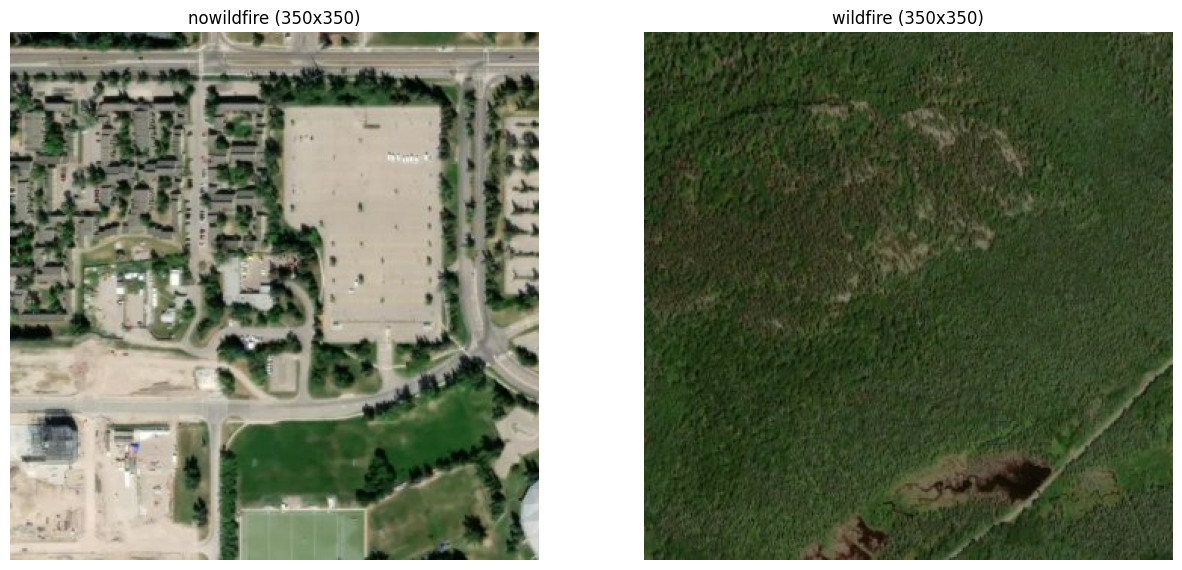

Validation set samples:


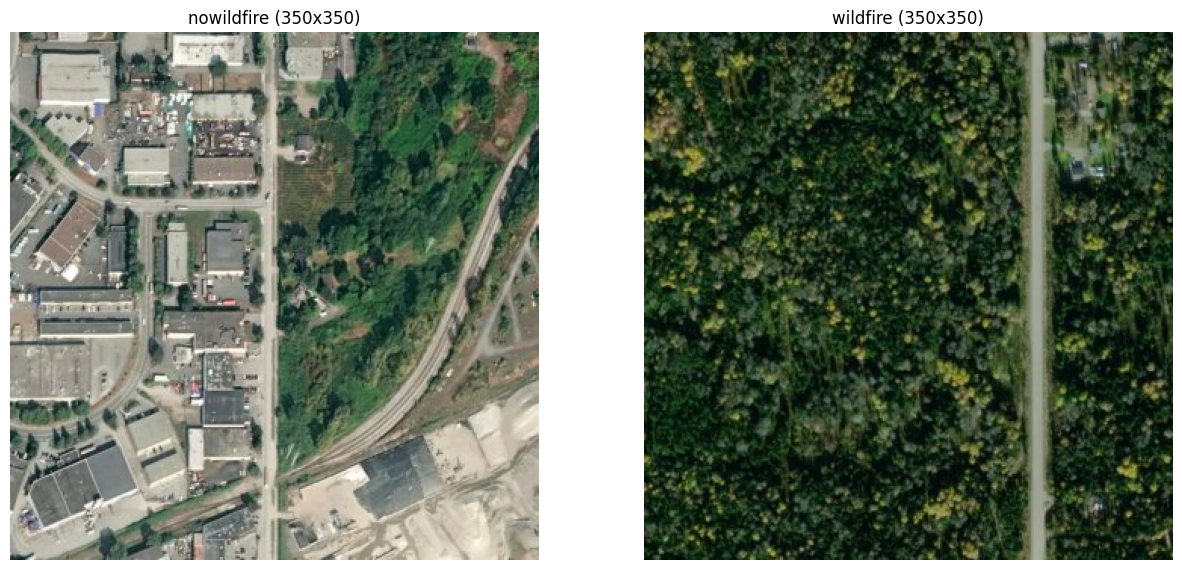

Test set samples:


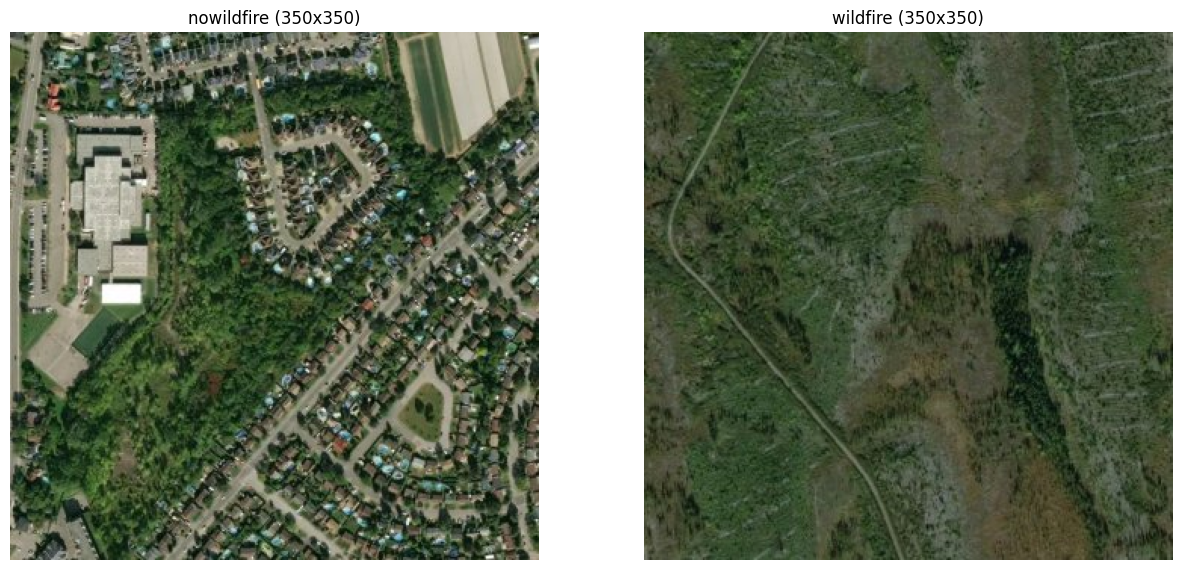

In [4]:
train_dir = 'fire_data/train'
valid_dir = 'fire_data/valid'
test_dir = 'fire_data/test'

print("Training set samples:")
display_random_sample(train_dir)

print("Validation set samples:")
display_random_sample(valid_dir)

print("Test set samples:")
display_random_sample(test_dir)

In [5]:
def load_data(directory, img_size=(32, 32)):
    X, Y = [], []
    for direct in os.listdir(directory):
        direct_path = os.path.join(directory, direct)
        if not os.path.isdir(direct_path):
            continue
        for filename in os.listdir(direct_path):
            img_path = os.path.join(direct_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            Y.append(direct)
    return np.array(X), np.array(Y)

x_train, y_train = load_data(train_dir)
x_val, y_val = load_data(valid_dir)
x_test, y_test = load_data(test_dir)

# Convert labels to binary
y_train = np.array([1 if label == 'wildfire' else 0 for label in y_train])
y_val = np.array([1 if label == 'wildfire' else 0 for label in y_val])
y_test = np.array([1 if label == 'wildfire' else 0 for label in y_test])

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

Premature end of JPEG file
Premature end of JPEG file


x_train shape: (30250, 32, 32, 3)
x_val shape: (6300, 32, 32, 3)
x_test shape: (6300, 32, 32, 3)
y_train shape: (30250,)
y_val shape: (6300,)
y_test shape: (6300,)


In [6]:
def build_model(input_shape, conv_layers, conv_filters, dense_units, dropout_rate, activation, optimizer, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for i in range(conv_layers):
        model.add(Conv2D(conv_filters[i], (3, 3), padding='same', activation=activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not recognized")

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(threshold=0.45)]
    )
    return model

In [7]:
sweep_config = {
    'method': 'bayes',  # could be 'grid', 'random'
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'conv_layers': {
            'values': [1, 2]
        },
        'dense_units': {
            'values': [64, 128, 256]
        },
        'dropout_rate': {
            'values': [0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'epochs': {
            'values': [20, 30, 40]
        }
    }
}

In [8]:
sweep_id = wandb.sweep(sweep_config, project="wildfire-sweep")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: dp3enr8c
Sweep URL: https://wandb.ai/katrinpochtar/wildfire-sweep/sweeps/dp3enr8c


In [9]:
def train():
  
    wandb.init(project="wildfire-sweep")
    config = wandb.config
    
    conv_layers = config.conv_layers
    conv_filters = [32]*conv_layers  # Keep simple
    dense_units = config.dense_units
    dropout_rate = config.dropout_rate
    activation = 'relu'
    optimizer = config.optimizer
    learning_rate = config.learning_rate
    epochs = config.epochs
    batch_size = 32

    model = build_model(
        input_shape=(32,32,3),
        conv_layers=conv_layers,
        conv_filters=conv_filters,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[WandbMetricsLogger(), WandbModelCheckpoint("model.keras"), early_stopping],
        verbose=1
    )

    # Evaluate on test data
    test_predictions = model.predict(x_test)
    y_pred = (test_predictions > 0.45).astype("int32").ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')

    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall,
        "test_f1_score": f1
    })
    wandb.finish()

In [10]:
wandb.agent(sweep_id, function=train, count=200)

wandb: Agent Starting Run: u9dwdff6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.
wandb: Currently logged in as: katrinpochtar. Use `wandb login --relogin` to force relogin


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8865 - loss: 0.2919 - val_binary_accuracy: 0.9400 - val_loss: 0.1600
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9283 - loss: 0.1911 - val_binary_accuracy: 0.9425 - val_loss: 0.1637
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9360 - loss: 0.1658 - val_binary_accuracy: 0.9475 - val_loss: 0.1430
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9433 - loss: 0.1489 - val_binary_accuracy: 0.9460 - val_loss: 0.1576
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9477 - loss: 0.1394 - val_binary_accuracy: 0.9510 - val_loss: 0.1331
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9543 - loss: 0.1217 - val_binary_accuracy: 0.9476 - val_loss: 0.1355
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9545 - loss: 0.1169 - val_binary_accuracy: 0.9503 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k6ro9dpl with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8793 - loss: 0.3089 - val_binary_accuracy: 0.9254 - val_loss: 0.2047
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9097 - loss: 0.2365 - val_binary_accuracy: 0.9287 - val_loss: 0.1930
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9151 - loss: 0.2236 - val_binary_accuracy: 0.9311 - val_loss: 0.1776
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9122 - loss: 0.2203 - val_binary_accuracy: 0.9335 - val_loss: 0.1703
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9183 - loss: 0.2055 - val_binary_accuracy: 0.9375 - val_loss: 0.1717
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9218 - loss: 0.1975 - val_binary_accuracy: 0.9397 - val_loss: 0.1683
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9253 - loss: 0.1931 - val_binary_accuracy: 0.9392 - val_loss: 

wandb: Agent Starting Run: nxcx02xp with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - binary_accuracy: 0.8971 - loss: 0.2683 - val_binary_accuracy: 0.9410 - val_loss: 0.1566
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9263 - loss: 0.1858 - val_binary_accuracy: 0.9454 - val_loss: 0.1434
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9375 - loss: 0.1619 - val_binary_accuracy: 0.9483 - val_loss: 0.1360
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9448 - loss: 0.1463 - val_binary_accuracy: 0.9481 - val_loss: 0.1360
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9498 - loss: 0.1332 - val_binary_accuracy: 0.9475 - val_loss: 0.1349
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9510 - loss: 0.1249 - val_binary_accuracy: 0.9544 - val_loss: 0.1298
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9573 - loss: 0.1140 - val_binary_accuracy: 0.9527 - val_loss:

wandb: Agent Starting Run: gu4fo4nz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9075 - loss: 0.3228 - val_binary_accuracy: 0.9383 - val_loss: 0.1722
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9402 - loss: 0.1650 - val_binary_accuracy: 0.8813 - val_loss: 0.3064
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9454 - loss: 0.1438 - val_binary_accuracy: 0.9416 - val_loss: 0.1616
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9549 - loss: 0.1232 - val_binary_accuracy: 0.9389 - val_loss: 0.1862
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9597 - loss: 0.1124 - val_binary_accuracy: 0.9487 - val_loss: 0.1534
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - binary_accuracy: 0.9655 - loss: 0.0957 - val_binary_accuracy: 0.8940 - val_loss: 0.4452
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9685 - loss: 0.0897 - val_binary_accuracy: 0.9284 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2l7jx40y with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9061 - loss: 0.2760 - val_binary_accuracy: 0.8860 - val_loss: 0.3567
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9405 - loss: 0.1595 - val_binary_accuracy: 0.9433 - val_loss: 0.1425
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9460 - loss: 0.1405 - val_binary_accuracy: 0.9479 - val_loss: 0.1288
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9514 - loss: 0.1257 - val_binary_accuracy: 0.9449 - val_loss: 0.1516
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9576 - loss: 0.1144 - val_binary_accuracy: 0.9422 - val_loss: 0.1615
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9619 - loss: 0.1021 - val_binary_accuracy: 0.9251 - val_loss: 0.1991
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9697 - loss: 0.0846 - val_binary_accuracy: 0.9151 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sqxvjzp9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8947 - loss: 0.2749 - val_binary_accuracy: 0.9417 - val_loss: 0.1587
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9288 - loss: 0.1836 - val_binary_accuracy: 0.9465 - val_loss: 0.1468
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9387 - loss: 0.1591 - val_binary_accuracy: 0.9476 - val_loss: 0.1438
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9506 - loss: 0.1319 - val_binary_accuracy: 0.9486 - val_loss: 0.1345
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9556 - loss: 0.1158 - val_binary_accuracy: 0.9438 - val_loss: 0.1549
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9632 - loss: 0.1006 - val_binary_accuracy: 0.9521 - val_loss: 0.1295
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9659 - loss: 0.0911 - val_binary_accuracy: 0.9432 - val_loss:

wandb: Agent Starting Run: k1f11pgl with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.8992 - loss: 0.3849 - val_binary_accuracy: 0.9408 - val_loss: 0.1576
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9350 - loss: 0.1743 - val_binary_accuracy: 0.9510 - val_loss: 0.1379
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9429 - loss: 0.1526 - val_binary_accuracy: 0.9465 - val_loss: 0.1441
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9476 - loss: 0.1364 - val_binary_accuracy: 0.9367 - val_loss: 0.2220
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9557 - loss: 0.1204 - val_binary_accuracy: 0.9454 - val_loss: 0.1824
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9623 - loss: 0.1084 - val_binary_accuracy: 0.8857 - val_loss: 0.4164
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j0h2sb6t with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8415 - loss: 0.4131 - val_binary_accuracy: 0.9051 - val_loss: 0.2995
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8832 - loss: 0.3243 - val_binary_accuracy: 0.9079 - val_loss: 0.2676
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8861 - loss: 0.2947 - val_binary_accuracy: 0.9087 - val_loss: 0.2485
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8889 - loss: 0.2794 - val_binary_accuracy: 0.9100 - val_loss: 0.2353
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8892 - loss: 0.2666 - val_binary_accuracy: 0.9137 - val_loss: 0.2268
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8947 - loss: 0.2594 - val_binary_accuracy: 0.9157 - val_loss: 0.2197
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8974 - loss: 0.2559 - val_binary_accuracy: 0.9203 - val_loss: 0.2152
Epoch 

wandb: Agent Starting Run: jt2bwcd2 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8518 - loss: 0.3654 - val_binary_accuracy: 0.9248 - val_loss: 0.1971
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9066 - loss: 0.2393 - val_binary_accuracy: 0.9332 - val_loss: 0.1804
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9087 - loss: 0.2305 - val_binary_accuracy: 0.9360 - val_loss: 0.1703
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9166 - loss: 0.2110 - val_binary_accuracy: 0.9298 - val_loss: 0.1916
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9155 - loss: 0.2132 - val_binary_accuracy: 0.9427 - val_loss: 0.1571
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9217 - loss: 0.2009 - val_binary_accuracy: 0.9427 - val_loss: 0.1553
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9264 - loss: 0.1894 - val_binary_accuracy: 0.9316 - val_loss:

wandb: Agent Starting Run: uqu77s4l with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9024 - loss: 0.2631 - val_binary_accuracy: 0.9346 - val_loss: 0.1866
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9348 - loss: 0.1711 - val_binary_accuracy: 0.9360 - val_loss: 0.1868
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9498 - loss: 0.1383 - val_binary_accuracy: 0.9459 - val_loss: 0.1468
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9597 - loss: 0.1147 - val_binary_accuracy: 0.9473 - val_loss: 0.1410
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9647 - loss: 0.0929 - val_binary_accuracy: 0.9406 - val_loss: 0.1493
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9719 - loss: 0.0790 - val_binary_accuracy: 0.9424 - val_loss: 0.1554
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9739 - loss: 0.0691 - val_binary_accuracy: 0.9465 - val_loss:

wandb: Agent Starting Run: 5tix8qje with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - binary_accuracy: 0.9061 - loss: 0.3362 - val_binary_accuracy: 0.9435 - val_loss: 0.1516
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9337 - loss: 0.1691 - val_binary_accuracy: 0.7079 - val_loss: 0.8237
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9469 - loss: 0.1424 - val_binary_accuracy: 0.9497 - val_loss: 0.1385
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9529 - loss: 0.1231 - val_binary_accuracy: 0.9462 - val_loss: 0.1432
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9579 - loss: 0.1069 - val_binary_accuracy: 0.9378 - val_loss: 0.1757
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - binary_accuracy: 0.9657 - loss: 0.0967 - val_binary_accuracy: 0.8903 - val_loss: 0.3517
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9689 - loss: 0.0852 - val_binary_accuracy: 0.9400 - val_loss:

wandb: Agent Starting Run: tyf4mdcj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8296 - loss: 0.4252 - val_binary_accuracy: 0.9079 - val_loss: 0.2881
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8865 - loss: 0.3211 - val_binary_accuracy: 0.9116 - val_loss: 0.2559
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8862 - loss: 0.2986 - val_binary_accuracy: 0.9149 - val_loss: 0.2372
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8947 - loss: 0.2741 - val_binary_accuracy: 0.9186 - val_loss: 0.2252
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8962 - loss: 0.2629 - val_binary_accuracy: 0.9229 - val_loss: 0.2166
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8993 - loss: 0.2626 - val_binary_accuracy: 0.9256 - val_loss: 0.2102
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.8988 - loss: 0.2562 - val_binary_accuracy: 0.9257 - val_loss: 0.2062
Epoc

wandb: Agent Starting Run: 1m4exs8f with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8997 - loss: 0.2670 - val_binary_accuracy: 0.9359 - val_loss: 0.1678
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9318 - loss: 0.1812 - val_binary_accuracy: 0.9394 - val_loss: 0.1646
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9489 - loss: 0.1412 - val_binary_accuracy: 0.9400 - val_loss: 0.1592
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9524 - loss: 0.1277 - val_binary_accuracy: 0.9433 - val_loss: 0.1616
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9653 - loss: 0.0979 - val_binary_accuracy: 0.9311 - val_loss: 0.1750
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9654 - loss: 0.0932 - val_binary_accuracy: 0.9449 - val_loss: 0.1585
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9711 - loss: 0.0820 - val_binary_accuracy: 0.9421 - val_loss:

wandb: Agent Starting Run: tsgsocg9 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8774 - loss: 0.3163 - val_binary_accuracy: 0.9240 - val_loss: 0.2101
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9072 - loss: 0.2405 - val_binary_accuracy: 0.9313 - val_loss: 0.1877
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9150 - loss: 0.2200 - val_binary_accuracy: 0.9338 - val_loss: 0.1740
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9173 - loss: 0.2096 - val_binary_accuracy: 0.9378 - val_loss: 0.1717
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9225 - loss: 0.2042 - val_binary_accuracy: 0.9381 - val_loss: 0.1688
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9251 - loss: 0.1894 - val_binary_accuracy: 0.9386 - val_loss: 0.1618
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9310 - loss: 0.1783 - val_binary_accuracy: 0.9411 - val_loss:

wandb: Agent Starting Run: eor3l6um with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9062 - loss: 0.2458 - val_binary_accuracy: 0.9448 - val_loss: 0.1431
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9317 - loss: 0.1749 - val_binary_accuracy: 0.9459 - val_loss: 0.1445
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9405 - loss: 0.1532 - val_binary_accuracy: 0.9506 - val_loss: 0.1436
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9473 - loss: 0.1398 - val_binary_accuracy: 0.9498 - val_loss: 0.1328
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9532 - loss: 0.1253 - val_binary_accuracy: 0.9519 - val_loss: 0.1308
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9583 - loss: 0.1129 - val_binary_accuracy: 0.9505 - val_loss: 0.1380
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9598 - loss: 0.1053 - val_binary_accuracy: 0.9524 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 81bvte6u with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8974 - loss: 0.3498 - val_binary_accuracy: 0.9237 - val_loss: 0.2147
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9323 - loss: 0.1773 - val_binary_accuracy: 0.9373 - val_loss: 0.1698
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9442 - loss: 0.1497 - val_binary_accuracy: 0.9368 - val_loss: 0.1780
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9525 - loss: 0.1314 - val_binary_accuracy: 0.8921 - val_loss: 0.2369
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9563 - loss: 0.1186 - val_binary_accuracy: 0.9416 - val_loss: 0.2037
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9585 - loss: 0.1158 - val_binary_accuracy: 0.9224 - val_loss: 0.2160
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: igkth03l with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8285 - loss: 0.4139 - val_binary_accuracy: 0.9065 - val_loss: 0.2711
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8878 - loss: 0.2994 - val_binary_accuracy: 0.9103 - val_loss: 0.2437
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8903 - loss: 0.2801 - val_binary_accuracy: 0.9159 - val_loss: 0.2286
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8922 - loss: 0.2698 - val_binary_accuracy: 0.9195 - val_loss: 0.2197
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8966 - loss: 0.2639 - val_binary_accuracy: 0.9208 - val_loss: 0.2141
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9023 - loss: 0.2570 - val_binary_accuracy: 0.9221 - val_loss: 0.2103
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9030 - loss: 0.2509 - val_binary_accuracy: 0.9221 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i4om07tm with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9008 - loss: 0.3020 - val_binary_accuracy: 0.9271 - val_loss: 0.1914
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9325 - loss: 0.1774 - val_binary_accuracy: 0.8627 - val_loss: 0.3395
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9437 - loss: 0.1460 - val_binary_accuracy: 0.9278 - val_loss: 0.2295
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9509 - loss: 0.1296 - val_binary_accuracy: 0.9481 - val_loss: 0.1490
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9576 - loss: 0.1145 - val_binary_accuracy: 0.9484 - val_loss: 0.1500
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9612 - loss: 0.1012 - val_binary_accuracy: 0.9487 - val_loss: 0.1598
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9674 - loss: 0.0876 - val_binary_accuracy: 0.9268 - val_loss:

wandb: Agent Starting Run: gn3t4e81 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.7905 - loss: 0.4641 - val_binary_accuracy: 0.8994 - val_loss: 0.2711
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8764 - loss: 0.3169 - val_binary_accuracy: 0.9025 - val_loss: 0.2501
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8819 - loss: 0.2976 - val_binary_accuracy: 0.9044 - val_loss: 0.2334
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8870 - loss: 0.2841 - val_binary_accuracy: 0.9073 - val_loss: 0.2226
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8875 - loss: 0.2793 - val_binary_accuracy: 0.9127 - val_loss: 0.2139
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8908 - loss: 0.2676 - val_binary_accuracy: 0.9184 - val_loss: 0.2068
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8965 - loss: 0.2618 - val_binary_accuracy: 0.9208 - val_loss:

wandb: Agent Starting Run: 15jfvioz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9002 - loss: 0.2736 - val_binary_accuracy: 0.9397 - val_loss: 0.1699
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9259 - loss: 0.1930 - val_binary_accuracy: 0.9398 - val_loss: 0.1506
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9400 - loss: 0.1589 - val_binary_accuracy: 0.9463 - val_loss: 0.1401
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9479 - loss: 0.1372 - val_binary_accuracy: 0.9459 - val_loss: 0.1591
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9535 - loss: 0.1227 - val_binary_accuracy: 0.9492 - val_loss: 0.1492
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9608 - loss: 0.1096 - val_binary_accuracy: 0.9463 - val_loss: 0.1376
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9611 - loss: 0.1007 - val_binary_accuracy: 0.9492 - val_loss: 0.1463
Epoch 

wandb: Agent Starting Run: uv57ym66 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9074 - loss: 0.2651 - val_binary_accuracy: 0.9456 - val_loss: 0.1516
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9325 - loss: 0.1732 - val_binary_accuracy: 0.7784 - val_loss: 0.5211
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9428 - loss: 0.1446 - val_binary_accuracy: 0.9527 - val_loss: 0.1219
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9523 - loss: 0.1257 - val_binary_accuracy: 0.9537 - val_loss: 0.1276
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9580 - loss: 0.1108 - val_binary_accuracy: 0.9417 - val_loss: 0.1683
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9623 - loss: 0.0994 - val_binary_accuracy: 0.9425 - val_loss: 0.1762
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9654 - loss: 0.0892 - val_binary_accuracy: 0.9221 - val_loss:

wandb: Agent Starting Run: 47uit719 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9040 - loss: 0.2915 - val_binary_accuracy: 0.9395 - val_loss: 0.1674
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9301 - loss: 0.1860 - val_binary_accuracy: 0.9376 - val_loss: 0.1654
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9427 - loss: 0.1571 - val_binary_accuracy: 0.9438 - val_loss: 0.1710
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9458 - loss: 0.1442 - val_binary_accuracy: 0.9462 - val_loss: 0.1619
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9504 - loss: 0.1331 - val_binary_accuracy: 0.9476 - val_loss: 0.1408
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9553 - loss: 0.1205 - val_binary_accuracy: 0.9397 - val_loss: 0.1778
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9609 - loss: 0.1131 - val_binary_accuracy: 0.9216 - val_loss: 0.2146
Epoc

wandb: Agent Starting Run: 71m7vrgp with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8954 - loss: 0.3474 - val_binary_accuracy: 0.8735 - val_loss: 0.2697
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9336 - loss: 0.1722 - val_binary_accuracy: 0.9470 - val_loss: 0.1482
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9478 - loss: 0.1441 - val_binary_accuracy: 0.9190 - val_loss: 0.2588
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9512 - loss: 0.1357 - val_binary_accuracy: 0.9340 - val_loss: 0.2012
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9547 - loss: 0.1203 - val_binary_accuracy: 0.9451 - val_loss: 0.1743
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9613 - loss: 0.1117 - val_binary_accuracy: 0.9463 - val_loss: 0.1793
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: n6iden25 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8976 - loss: 0.2700 - val_binary_accuracy: 0.9348 - val_loss: 0.1794
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9257 - loss: 0.1937 - val_binary_accuracy: 0.9473 - val_loss: 0.1401
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9345 - loss: 0.1729 - val_binary_accuracy: 0.9481 - val_loss: 0.1403
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9399 - loss: 0.1561 - val_binary_accuracy: 0.9502 - val_loss: 0.1353
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9431 - loss: 0.1470 - val_binary_accuracy: 0.9516 - val_loss: 0.1330
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9506 - loss: 0.1314 - val_binary_accuracy: 0.9529 - val_loss: 0.1307
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9503 - loss: 0.1261 - val_binary_accuracy: 0.9532 - val_loss:

wandb: Agent Starting Run: uoeks7i8 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8992 - loss: 0.2810 - val_binary_accuracy: 0.9398 - val_loss: 0.1591
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - binary_accuracy: 0.9302 - loss: 0.1856 - val_binary_accuracy: 0.9430 - val_loss: 0.1608
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9420 - loss: 0.1487 - val_binary_accuracy: 0.9463 - val_loss: 0.1431
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - binary_accuracy: 0.9515 - loss: 0.1301 - val_binary_accuracy: 0.9486 - val_loss: 0.1423
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9595 - loss: 0.1110 - val_binary_accuracy: 0.9433 - val_loss: 0.1694
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9646 - loss: 0.0931 - val_binary_accuracy: 0.9356 - val_loss: 0.1640
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9699 - loss: 0.0827 - val_binary_accuracy: 0.9473 - val_loss:

wandb: Agent Starting Run: e57dgto5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.7139 - loss: 0.5918 - val_binary_accuracy: 0.8992 - val_loss: 0.2869
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8821 - loss: 0.3098 - val_binary_accuracy: 0.9030 - val_loss: 0.2588
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8883 - loss: 0.2926 - val_binary_accuracy: 0.9044 - val_loss: 0.2402
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8914 - loss: 0.2722 - val_binary_accuracy: 0.9094 - val_loss: 0.2267
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8953 - loss: 0.2646 - val_binary_accuracy: 0.9110 - val_loss: 0.2176
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8972 - loss: 0.2557 - val_binary_accuracy: 0.9137 - val_loss: 0.2110
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8975 - loss: 0.2536 - val_binary_accuracy: 0.9186 - val_loss:

wandb: Agent Starting Run: t0xmddp6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.8925 - loss: 0.2801 - val_binary_accuracy: 0.9417 - val_loss: 0.1555
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9265 - loss: 0.1910 - val_binary_accuracy: 0.9475 - val_loss: 0.1472
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9356 - loss: 0.1683 - val_binary_accuracy: 0.9394 - val_loss: 0.1491
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9384 - loss: 0.1561 - val_binary_accuracy: 0.9506 - val_loss: 0.1336
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9417 - loss: 0.1473 - val_binary_accuracy: 0.9502 - val_loss: 0.1285
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9530 - loss: 0.1248 - val_binary_accuracy: 0.9360 - val_loss: 0.1542
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9502 - loss: 0.1269 - val_binary_accuracy: 0.9541 - val_loss:

wandb: Agent Starting Run: 5lnwcl4s with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8843 - loss: 0.2876 - val_binary_accuracy: 0.9444 - val_loss: 0.1486
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9261 - loss: 0.1872 - val_binary_accuracy: 0.9479 - val_loss: 0.1405
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9372 - loss: 0.1629 - val_binary_accuracy: 0.9457 - val_loss: 0.1422
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9446 - loss: 0.1446 - val_binary_accuracy: 0.9479 - val_loss: 0.1335
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9490 - loss: 0.1341 - val_binary_accuracy: 0.9373 - val_loss: 0.1842
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9542 - loss: 0.1230 - val_binary_accuracy: 0.9489 - val_loss: 0.1393
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9585 - loss: 0.1145 - val_binary_accuracy: 0.9519 - val_loss:

wandb: Agent Starting Run: jzo1rzpj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9003 - loss: 0.3574 - val_binary_accuracy: 0.9243 - val_loss: 0.1902
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9323 - loss: 0.1797 - val_binary_accuracy: 0.9438 - val_loss: 0.1578
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9430 - loss: 0.1505 - val_binary_accuracy: 0.9130 - val_loss: 0.2466
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9522 - loss: 0.1307 - val_binary_accuracy: 0.9465 - val_loss: 0.1563
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9594 - loss: 0.1117 - val_binary_accuracy: 0.9459 - val_loss: 0.1568
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9618 - loss: 0.1067 - val_binary_accuracy: 0.9486 - val_loss: 0.1731
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9677 - loss: 0.0913 - val_binary_accuracy: 0.9284 - val_loss:

wandb: Agent Starting Run: 7i1767dg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9066 - loss: 0.2882 - val_binary_accuracy: 0.9371 - val_loss: 0.1783
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9347 - loss: 0.1714 - val_binary_accuracy: 0.9521 - val_loss: 0.1301
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9455 - loss: 0.1481 - val_binary_accuracy: 0.9440 - val_loss: 0.1655
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9515 - loss: 0.1290 - val_binary_accuracy: 0.9386 - val_loss: 0.2009
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9546 - loss: 0.1189 - val_binary_accuracy: 0.9565 - val_loss: 0.1316
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9607 - loss: 0.1091 - val_binary_accuracy: 0.9381 - val_loss: 0.2314
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: e78hnayd with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9070 - loss: 0.2738 - val_binary_accuracy: 0.9433 - val_loss: 0.1552
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9357 - loss: 0.1687 - val_binary_accuracy: 0.9386 - val_loss: 0.1604
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9470 - loss: 0.1400 - val_binary_accuracy: 0.9457 - val_loss: 0.1514
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9538 - loss: 0.1248 - val_binary_accuracy: 0.9395 - val_loss: 0.1540
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9591 - loss: 0.1105 - val_binary_accuracy: 0.9110 - val_loss: 0.2610
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9630 - loss: 0.1064 - val_binary_accuracy: 0.9329 - val_loss: 0.2076
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9676 - loss: 0.0864 - val_binary_accuracy: 0.9305 - val_loss: 0.2039
197/

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ivn0zeaz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9057 - loss: 0.2654 - val_binary_accuracy: 0.9376 - val_loss: 0.1494
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9333 - loss: 0.1780 - val_binary_accuracy: 0.9375 - val_loss: 0.1560
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9386 - loss: 0.1606 - val_binary_accuracy: 0.8830 - val_loss: 0.3241
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9487 - loss: 0.1383 - val_binary_accuracy: 0.9440 - val_loss: 0.1859
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9506 - loss: 0.1297 - val_binary_accuracy: 0.9137 - val_loss: 0.2962
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: y1mb2m9c with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8912 - loss: 0.3241 - val_binary_accuracy: 0.9357 - val_loss: 0.1787
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9299 - loss: 0.1875 - val_binary_accuracy: 0.9468 - val_loss: 0.1466
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9395 - loss: 0.1519 - val_binary_accuracy: 0.8863 - val_loss: 0.3496
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9482 - loss: 0.1323 - val_binary_accuracy: 0.9394 - val_loss: 0.1814
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9545 - loss: 0.1229 - val_binary_accuracy: 0.9379 - val_loss: 0.1784
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9577 - loss: 0.1153 - val_binary_accuracy: 0.9319 - val_loss: 0.2333
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: xh8hmd8d with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8968 - loss: 0.2699 - val_binary_accuracy: 0.9360 - val_loss: 0.1763
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9271 - loss: 0.1822 - val_binary_accuracy: 0.9463 - val_loss: 0.1372
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9416 - loss: 0.1513 - val_binary_accuracy: 0.9421 - val_loss: 0.1433
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9479 - loss: 0.1382 - val_binary_accuracy: 0.9529 - val_loss: 0.1306
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9531 - loss: 0.1236 - val_binary_accuracy: 0.9549 - val_loss: 0.1229
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9569 - loss: 0.1122 - val_binary_accuracy: 0.9551 - val_loss: 0.1226
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9628 - loss: 0.0973 - val_binary_accuracy: 0.9567 - val_loss:

wandb: Agent Starting Run: cep7q5bd with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8668 - loss: 0.3343 - val_binary_accuracy: 0.9206 - val_loss: 0.2063
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9095 - loss: 0.2385 - val_binary_accuracy: 0.9263 - val_loss: 0.1966
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9116 - loss: 0.2284 - val_binary_accuracy: 0.9270 - val_loss: 0.1926
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9129 - loss: 0.2228 - val_binary_accuracy: 0.9325 - val_loss: 0.1821
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9194 - loss: 0.2039 - val_binary_accuracy: 0.9317 - val_loss: 0.1745
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9194 - loss: 0.2110 - val_binary_accuracy: 0.9344 - val_loss: 0.1741
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9219 - loss: 0.1991 - val_binary_accuracy: 0.9365 - val_loss: 0.1672
E

wandb: Agent Starting Run: 0jxnss9m with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - binary_accuracy: 0.9011 - loss: 0.3244 - val_binary_accuracy: 0.9365 - val_loss: 0.1617
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9326 - loss: 0.1733 - val_binary_accuracy: 0.9422 - val_loss: 0.1506
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9453 - loss: 0.1428 - val_binary_accuracy: 0.9487 - val_loss: 0.1410
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9538 - loss: 0.1204 - val_binary_accuracy: 0.9332 - val_loss: 0.2513
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9592 - loss: 0.1115 - val_binary_accuracy: 0.9429 - val_loss: 0.1714
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9651 - loss: 0.0931 - val_binary_accuracy: 0.9476 - val_loss: 0.1629
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9699 - loss: 0.0800 - val_binary_accuracy: 0.9405 - val_loss: 0.1789
197/19

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jtc8ug8l with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9003 - loss: 0.2747 - val_binary_accuracy: 0.9486 - val_loss: 0.1346
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9340 - loss: 0.1765 - val_binary_accuracy: 0.9430 - val_loss: 0.1695
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9401 - loss: 0.1574 - val_binary_accuracy: 0.9552 - val_loss: 0.1187
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9489 - loss: 0.1395 - val_binary_accuracy: 0.9473 - val_loss: 0.1590
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9504 - loss: 0.1295 - val_binary_accuracy: 0.9454 - val_loss: 0.1540
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9537 - loss: 0.1247 - val_binary_accuracy: 0.9538 - val_loss: 0.1268
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9580 - loss: 0.1133 - val_binary_accuracy: 0.9071 - val_loss:

wandb: Agent Starting Run: s8kr0zym with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9045 - loss: 0.3301 - val_binary_accuracy: 0.9341 - val_loss: 0.1645
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9358 - loss: 0.1685 - val_binary_accuracy: 0.9276 - val_loss: 0.2126
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9470 - loss: 0.1405 - val_binary_accuracy: 0.9398 - val_loss: 0.1691
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9554 - loss: 0.1196 - val_binary_accuracy: 0.9470 - val_loss: 0.1517
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9628 - loss: 0.0991 - val_binary_accuracy: 0.9354 - val_loss: 0.1661
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9655 - loss: 0.0940 - val_binary_accuracy: 0.9463 - val_loss: 0.1438
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9742 - loss: 0.0734 - val_binary_accuracy: 0.9246 - val_loss: 0.2682
E

wandb: Agent Starting Run: kwzfbx4l with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8985 - loss: 0.3128 - val_binary_accuracy: 0.9343 - val_loss: 0.1738
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9356 - loss: 0.1683 - val_binary_accuracy: 0.9413 - val_loss: 0.1795
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9478 - loss: 0.1398 - val_binary_accuracy: 0.6354 - val_loss: 1.5571
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9527 - loss: 0.1300 - val_binary_accuracy: 0.8887 - val_loss: 0.3162
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9573 - loss: 0.1193 - val_binary_accuracy: 0.9427 - val_loss: 0.2472
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2y04qfgj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8803 - loss: 0.3025 - val_binary_accuracy: 0.9205 - val_loss: 0.2014
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9086 - loss: 0.2348 - val_binary_accuracy: 0.9262 - val_loss: 0.1890
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9103 - loss: 0.2245 - val_binary_accuracy: 0.9298 - val_loss: 0.1815
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9191 - loss: 0.2103 - val_binary_accuracy: 0.9348 - val_loss: 0.1772
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9184 - loss: 0.2075 - val_binary_accuracy: 0.9349 - val_loss: 0.1701
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9194 - loss: 0.2010 - val_binary_accuracy: 0.9375 - val_loss: 0.1601
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9292 - loss: 0.1875 - val_binary_accuracy: 0.9392 - val_loss: 0.1562
Epoch 

wandb: Agent Starting Run: 2jornv90 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8976 - loss: 0.2612 - val_binary_accuracy: 0.9416 - val_loss: 0.1524
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9304 - loss: 0.1800 - val_binary_accuracy: 0.9443 - val_loss: 0.1604
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9407 - loss: 0.1518 - val_binary_accuracy: 0.9505 - val_loss: 0.1333
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9490 - loss: 0.1342 - val_binary_accuracy: 0.9456 - val_loss: 0.1350
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9498 - loss: 0.1266 - val_binary_accuracy: 0.9484 - val_loss: 0.1528
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9594 - loss: 0.1097 - val_binary_accuracy: 0.9379 - val_loss: 0.1642
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9629 - loss: 0.1004 - val_binary_accuracy: 0.9517 - val_loss:

wandb: Agent Starting Run: xg4wsh81 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9001 - loss: 0.2647 - val_binary_accuracy: 0.9392 - val_loss: 0.1533
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9327 - loss: 0.1770 - val_binary_accuracy: 0.9460 - val_loss: 0.1433
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9471 - loss: 0.1371 - val_binary_accuracy: 0.9463 - val_loss: 0.1433
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9592 - loss: 0.1110 - val_binary_accuracy: 0.9487 - val_loss: 0.1346
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9662 - loss: 0.0945 - val_binary_accuracy: 0.9460 - val_loss: 0.1545
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9725 - loss: 0.0780 - val_binary_accuracy: 0.9516 - val_loss: 0.1385
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9771 - loss: 0.0701 - val_binary_accuracy: 0.9475 - val_loss: 0.

wandb: Agent Starting Run: 6scrqlxb with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8021 - loss: 0.4449 - val_binary_accuracy: 0.9071 - val_loss: 0.2772
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8893 - loss: 0.3004 - val_binary_accuracy: 0.9106 - val_loss: 0.2501
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8876 - loss: 0.2873 - val_binary_accuracy: 0.9132 - val_loss: 0.2339
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8917 - loss: 0.2748 - val_binary_accuracy: 0.9170 - val_loss: 0.2248
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8960 - loss: 0.2635 - val_binary_accuracy: 0.9192 - val_loss: 0.2185
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9005 - loss: 0.2604 - val_binary_accuracy: 0.9206 - val_loss: 0.2134
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8983 - loss: 0.2617 - val_binary_accuracy: 0.9225 - val_loss: 0.2102
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ugqq1g4r with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8949 - loss: 0.2988 - val_binary_accuracy: 0.8954 - val_loss: 0.3385
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9347 - loss: 0.1760 - val_binary_accuracy: 0.8725 - val_loss: 0.4778
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9435 - loss: 0.1438 - val_binary_accuracy: 0.9057 - val_loss: 0.2676
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9491 - loss: 0.1370 - val_binary_accuracy: 0.9513 - val_loss: 0.1326
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9553 - loss: 0.1190 - val_binary_accuracy: 0.9363 - val_loss: 0.1759
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9592 - loss: 0.1123 - val_binary_accuracy: 0.9462 - val_loss: 0.1621
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9641 - loss: 0.0999 - val_binary_accuracy: 0.9471 - val_loss:

wandb: Agent Starting Run: btjvrgzg with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9059 - loss: 0.2536 - val_binary_accuracy: 0.9419 - val_loss: 0.1511
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9408 - loss: 0.1605 - val_binary_accuracy: 0.9451 - val_loss: 0.1397
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9492 - loss: 0.1306 - val_binary_accuracy: 0.9481 - val_loss: 0.1335
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9610 - loss: 0.1052 - val_binary_accuracy: 0.9459 - val_loss: 0.1573
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9683 - loss: 0.0870 - val_binary_accuracy: 0.9514 - val_loss: 0.1329
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9727 - loss: 0.0741 - val_binary_accuracy: 0.9392 - val_loss: 0.1846
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9774 - loss: 0.0647 - val_binary_accuracy: 0.9506 - val_loss:

wandb: Agent Starting Run: 7pwgqxmn with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8983 - loss: 0.2616 - val_binary_accuracy: 0.9395 - val_loss: 0.1690
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9304 - loss: 0.1841 - val_binary_accuracy: 0.9467 - val_loss: 0.1502
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9420 - loss: 0.1520 - val_binary_accuracy: 0.9525 - val_loss: 0.1273
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9433 - loss: 0.1472 - val_binary_accuracy: 0.9481 - val_loss: 0.1470
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9533 - loss: 0.1243 - val_binary_accuracy: 0.9514 - val_loss: 0.1305
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9518 - loss: 0.1251 - val_binary_accuracy: 0.9281 - val_loss: 0.1777
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - binary_accuracy: 0.9566 - loss: 0.1142 - val_binary_accuracy: 0.9514 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s4pwe4s7 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8981 - loss: 0.2964 - val_binary_accuracy: 0.8914 - val_loss: 0.2737
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9327 - loss: 0.1779 - val_binary_accuracy: 0.9398 - val_loss: 0.1631
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9430 - loss: 0.1506 - val_binary_accuracy: 0.9375 - val_loss: 0.1722
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9483 - loss: 0.1417 - val_binary_accuracy: 0.9106 - val_loss: 0.3185
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9494 - loss: 0.1321 - val_binary_accuracy: 0.9359 - val_loss: 0.2377
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9550 - loss: 0.1174 - val_binary_accuracy: 0.8513 - val_loss: 1.2405
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7o53xz2g with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8978 - loss: 0.2694 - val_binary_accuracy: 0.9427 - val_loss: 0.1535
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9259 - loss: 0.1926 - val_binary_accuracy: 0.9468 - val_loss: 0.1480
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9361 - loss: 0.1632 - val_binary_accuracy: 0.9510 - val_loss: 0.1288
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9454 - loss: 0.1435 - val_binary_accuracy: 0.9457 - val_loss: 0.1574
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9474 - loss: 0.1322 - val_binary_accuracy: 0.9532 - val_loss: 0.1304
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9521 - loss: 0.1231 - val_binary_accuracy: 0.9376 - val_loss: 0.1820
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9534 - loss: 0.1183 - val_binary_accuracy: 0.9537 - val_loss:

wandb: Agent Starting Run: 1pquyfd7 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8980 - loss: 0.3093 - val_binary_accuracy: 0.9433 - val_loss: 0.1624
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9325 - loss: 0.1739 - val_binary_accuracy: 0.9441 - val_loss: 0.1500
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9396 - loss: 0.1555 - val_binary_accuracy: 0.8173 - val_loss: 0.4278
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9476 - loss: 0.1386 - val_binary_accuracy: 0.9538 - val_loss: 0.1422
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9518 - loss: 0.1285 - val_binary_accuracy: 0.9470 - val_loss: 0.1694
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9514 - loss: 0.1236 - val_binary_accuracy: 0.9481 - val_loss: 0.1610
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9579 - loss: 0.1134 - val_binary_accuracy: 0.9208 - val_loss:

wandb: Agent Starting Run: fqbsr2wu with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9066 - loss: 0.2969 - val_binary_accuracy: 0.9454 - val_loss: 0.1472
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9317 - loss: 0.1734 - val_binary_accuracy: 0.9363 - val_loss: 0.1857
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9440 - loss: 0.1430 - val_binary_accuracy: 0.9425 - val_loss: 0.1532
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9503 - loss: 0.1279 - val_binary_accuracy: 0.9557 - val_loss: 0.1189
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9502 - loss: 0.1233 - val_binary_accuracy: 0.9205 - val_loss: 0.2210
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9602 - loss: 0.1089 - val_binary_accuracy: 0.9425 - val_loss: 0.1589
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9666 - loss: 0.0915 - val_binary_accuracy: 0.7260 - val_loss:

wandb: Agent Starting Run: t8y686i6 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8047 - loss: 0.4573 - val_binary_accuracy: 0.9070 - val_loss: 0.2851
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8823 - loss: 0.3187 - val_binary_accuracy: 0.9105 - val_loss: 0.2596
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8891 - loss: 0.2992 - val_binary_accuracy: 0.9108 - val_loss: 0.2421
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8928 - loss: 0.2794 - val_binary_accuracy: 0.9127 - val_loss: 0.2297
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8912 - loss: 0.2718 - val_binary_accuracy: 0.9159 - val_loss: 0.2217
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8960 - loss: 0.2587 - val_binary_accuracy: 0.9200 - val_loss: 0.2169
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8999 - loss: 0.2520 - val_binary_accuracy: 0.9235 - val_loss:

wandb: Agent Starting Run: t525o16h with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8981 - loss: 0.2661 - val_binary_accuracy: 0.9389 - val_loss: 0.1693
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9316 - loss: 0.1740 - val_binary_accuracy: 0.9456 - val_loss: 0.1418
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9428 - loss: 0.1520 - val_binary_accuracy: 0.9471 - val_loss: 0.1391
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9515 - loss: 0.1295 - val_binary_accuracy: 0.9467 - val_loss: 0.1366
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - binary_accuracy: 0.9566 - loss: 0.1169 - val_binary_accuracy: 0.9503 - val_loss: 0.1422
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9594 - loss: 0.1056 - val_binary_accuracy: 0.9497 - val_loss: 0.1359
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9658 - loss: 0.0911 - val_binary_accuracy: 0.9502 - val_loss: 0.1438


wandb: Agent Starting Run: cqkimra6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8894 - loss: 0.2768 - val_binary_accuracy: 0.9394 - val_loss: 0.1717
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9255 - loss: 0.1971 - val_binary_accuracy: 0.9403 - val_loss: 0.1678
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9330 - loss: 0.1731 - val_binary_accuracy: 0.9494 - val_loss: 0.1367
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9384 - loss: 0.1587 - val_binary_accuracy: 0.9490 - val_loss: 0.1266
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9438 - loss: 0.1476 - val_binary_accuracy: 0.9505 - val_loss: 0.1321
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9469 - loss: 0.1397 - val_binary_accuracy: 0.9530 - val_loss: 0.1372
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9554 - loss: 0.1196 - val_binary_accuracy: 0.9525 - val_loss:

wandb: Agent Starting Run: 4a0crmmc with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8697 - loss: 0.3368 - val_binary_accuracy: 0.9237 - val_loss: 0.2043
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9023 - loss: 0.2442 - val_binary_accuracy: 0.9321 - val_loss: 0.1861
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9103 - loss: 0.2284 - val_binary_accuracy: 0.9352 - val_loss: 0.1744
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9218 - loss: 0.2067 - val_binary_accuracy: 0.9349 - val_loss: 0.1755
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9213 - loss: 0.2053 - val_binary_accuracy: 0.9378 - val_loss: 0.1727
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9252 - loss: 0.1972 - val_binary_accuracy: 0.9422 - val_loss: 0.1560
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9258 - loss: 0.1878 - val_binary_accuracy: 0.9430 - val_loss: 0.1528
Epoch 

wandb: Agent Starting Run: 1tmv3ywr with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8750 - loss: 0.3228 - val_binary_accuracy: 0.9244 - val_loss: 0.2110
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9077 - loss: 0.2429 - val_binary_accuracy: 0.9262 - val_loss: 0.1951
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9095 - loss: 0.2332 - val_binary_accuracy: 0.9268 - val_loss: 0.1837
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9139 - loss: 0.2215 - val_binary_accuracy: 0.9308 - val_loss: 0.1813
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9158 - loss: 0.2165 - val_binary_accuracy: 0.9337 - val_loss: 0.1746
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9211 - loss: 0.2026 - val_binary_accuracy: 0.9333 - val_loss: 0.1733
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9215 - loss: 0.1985 - val_binary_accuracy: 0.9373 - val_loss: 0.1631
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ahi1is6a with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.7990 - loss: 0.4662 - val_binary_accuracy: 0.9048 - val_loss: 0.2993
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8805 - loss: 0.3258 - val_binary_accuracy: 0.9089 - val_loss: 0.2643
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8897 - loss: 0.2935 - val_binary_accuracy: 0.9114 - val_loss: 0.2431
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8903 - loss: 0.2814 - val_binary_accuracy: 0.9146 - val_loss: 0.2289
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8925 - loss: 0.2701 - val_binary_accuracy: 0.9190 - val_loss: 0.2206
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8925 - loss: 0.2602 - val_binary_accuracy: 0.9214 - val_loss: 0.2149
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8968 - loss: 0.2570 - val_binary_accuracy: 0.9238 - val_loss: 0

wandb: Agent Starting Run: 1ksbe0kv with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - binary_accuracy: 0.8971 - loss: 0.2817 - val_binary_accuracy: 0.9430 - val_loss: 0.1536
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9392 - loss: 0.1637 - val_binary_accuracy: 0.9384 - val_loss: 0.1587
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9520 - loss: 0.1271 - val_binary_accuracy: 0.9473 - val_loss: 0.1420
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9610 - loss: 0.1081 - val_binary_accuracy: 0.9487 - val_loss: 0.1444
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9693 - loss: 0.0859 - val_binary_accuracy: 0.9397 - val_loss: 0.1578
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9713 - loss: 0.0793 - val_binary_accuracy: 0.9448 - val_loss: 0.1497
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9766 - loss: 0.0633 - val_binary_accuracy: 0.9457 - val_loss:

wandb: Agent Starting Run: 1lyqjmui with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9088 - loss: 0.2462 - val_binary_accuracy: 0.9390 - val_loss: 0.1671
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9374 - loss: 0.1671 - val_binary_accuracy: 0.9363 - val_loss: 0.1604
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9452 - loss: 0.1466 - val_binary_accuracy: 0.9397 - val_loss: 0.1729
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9479 - loss: 0.1313 - val_binary_accuracy: 0.9508 - val_loss: 0.1373
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9553 - loss: 0.1169 - val_binary_accuracy: 0.9478 - val_loss: 0.1328
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9607 - loss: 0.1060 - val_binary_accuracy: 0.9457 - val_loss: 0.1598
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9654 - loss: 0.0914 - val_binary_accuracy: 0.8838 - val_loss:

wandb: Agent Starting Run: trvtgez9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9011 - loss: 0.2605 - val_binary_accuracy: 0.9384 - val_loss: 0.1578
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9276 - loss: 0.1843 - val_binary_accuracy: 0.9465 - val_loss: 0.1545
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9373 - loss: 0.1620 - val_binary_accuracy: 0.9452 - val_loss: 0.1449
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9406 - loss: 0.1520 - val_binary_accuracy: 0.9487 - val_loss: 0.1440
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9507 - loss: 0.1299 - val_binary_accuracy: 0.9413 - val_loss: 0.1399
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9537 - loss: 0.1212 - val_binary_accuracy: 0.9521 - val_loss: 0.1261
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9574 - loss: 0.1109 - val_binary_accuracy: 0.9487 - val_loss:

wandb: Agent Starting Run: 0rzmzg8r with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.7140 - loss: 0.6065 - val_binary_accuracy: 0.8992 - val_loss: 0.2678
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8796 - loss: 0.3133 - val_binary_accuracy: 0.9048 - val_loss: 0.2493
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8844 - loss: 0.2924 - val_binary_accuracy: 0.9090 - val_loss: 0.2387
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8875 - loss: 0.2818 - val_binary_accuracy: 0.9140 - val_loss: 0.2294
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8931 - loss: 0.2707 - val_binary_accuracy: 0.9181 - val_loss: 0.2211
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8970 - loss: 0.2681 - val_binary_accuracy: 0.9190 - val_loss: 0.2170
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8984 - loss: 0.2607 - val_binary_accuracy: 0.9187 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g3zcnvsu with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8100 - loss: 0.4551 - val_binary_accuracy: 0.8984 - val_loss: 0.2856
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8820 - loss: 0.3212 - val_binary_accuracy: 0.9046 - val_loss: 0.2631
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8848 - loss: 0.2993 - val_binary_accuracy: 0.9048 - val_loss: 0.2459
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8838 - loss: 0.2940 - val_binary_accuracy: 0.9067 - val_loss: 0.2343
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8886 - loss: 0.2795 - val_binary_accuracy: 0.9083 - val_loss: 0.2248
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8866 - loss: 0.2763 - val_binary_accuracy: 0.9124 - val_loss: 0.2172
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8947 - loss: 0.2692 - val_binary_accuracy: 0.9173 - val_loss:

wandb: Agent Starting Run: bzssu2r9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8710 - loss: 0.3281 - val_binary_accuracy: 0.9222 - val_loss: 0.1957
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9038 - loss: 0.2458 - val_binary_accuracy: 0.9327 - val_loss: 0.1818
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9140 - loss: 0.2203 - val_binary_accuracy: 0.9367 - val_loss: 0.1647
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9177 - loss: 0.2138 - val_binary_accuracy: 0.9378 - val_loss: 0.1658
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9214 - loss: 0.2032 - val_binary_accuracy: 0.9402 - val_loss: 0.1614
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9246 - loss: 0.1928 - val_binary_accuracy: 0.9421 - val_loss: 0.1520
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9240 - loss: 0.1938 - val_binary_accuracy: 0.8479 - val_loss:

wandb: Agent Starting Run: wmjpzu2j with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8947 - loss: 0.3449 - val_binary_accuracy: 0.9392 - val_loss: 0.1528
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9319 - loss: 0.1771 - val_binary_accuracy: 0.8927 - val_loss: 0.2758
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9448 - loss: 0.1518 - val_binary_accuracy: 0.9376 - val_loss: 0.1555
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9491 - loss: 0.1349 - val_binary_accuracy: 0.9283 - val_loss: 0.1778
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9538 - loss: 0.1265 - val_binary_accuracy: 0.9341 - val_loss: 0.1802
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


wandb: Agent Starting Run: 3o93b5pq with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8328 - loss: 0.4112 - val_binary_accuracy: 0.9059 - val_loss: 0.2856
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8830 - loss: 0.3171 - val_binary_accuracy: 0.9081 - val_loss: 0.2587
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8853 - loss: 0.2997 - val_binary_accuracy: 0.9098 - val_loss: 0.2413
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8887 - loss: 0.2854 - val_binary_accuracy: 0.9106 - val_loss: 0.2317
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8924 - loss: 0.2704 - val_binary_accuracy: 0.9125 - val_loss: 0.2228
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8954 - loss: 0.2607 - val_binary_accuracy: 0.9149 - val_loss: 0.2172
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8968 - loss: 0.2560 - val_binary_accuracy: 0.9176 - val_loss: 

wandb: Agent Starting Run: pnhrnafq with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8966 - loss: 0.2712 - val_binary_accuracy: 0.9424 - val_loss: 0.1558
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9280 - loss: 0.1795 - val_binary_accuracy: 0.9486 - val_loss: 0.1348
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9383 - loss: 0.1591 - val_binary_accuracy: 0.9525 - val_loss: 0.1265
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9465 - loss: 0.1392 - val_binary_accuracy: 0.9535 - val_loss: 0.1276
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9485 - loss: 0.1341 - val_binary_accuracy: 0.9530 - val_loss: 0.1213
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9581 - loss: 0.1126 - val_binary_accuracy: 0.9505 - val_loss: 0.1236
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9590 - loss: 0.1075 - val_binary_accuracy: 0.9532 - val_loss:

wandb: Agent Starting Run: bjuof797 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9008 - loss: 0.2687 - val_binary_accuracy: 0.9384 - val_loss: 0.1676
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9305 - loss: 0.1829 - val_binary_accuracy: 0.9468 - val_loss: 0.1526
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9433 - loss: 0.1517 - val_binary_accuracy: 0.9484 - val_loss: 0.1445
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9509 - loss: 0.1282 - val_binary_accuracy: 0.9379 - val_loss: 0.1771
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9577 - loss: 0.1105 - val_binary_accuracy: 0.9481 - val_loss: 0.1339
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9648 - loss: 0.0970 - val_binary_accuracy: 0.9457 - val_loss: 0.1551
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9678 - loss: 0.0882 - val_binary_accuracy: 0.9475 - val_loss: 0.1565
Epoch

wandb: Agent Starting Run: 5wf8638w with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8997 - loss: 0.2997 - val_binary_accuracy: 0.9317 - val_loss: 0.1832
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9349 - loss: 0.1737 - val_binary_accuracy: 0.9478 - val_loss: 0.1534
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9420 - loss: 0.1610 - val_binary_accuracy: 0.9165 - val_loss: 0.2347
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9488 - loss: 0.1349 - val_binary_accuracy: 0.8314 - val_loss: 0.6965
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9514 - loss: 0.1268 - val_binary_accuracy: 0.8406 - val_loss: 0.4143
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9549 - loss: 0.1210 - val_binary_accuracy: 0.9140 - val_loss: 0.2487
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


wandb: Agent Starting Run: uby3bs39 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9103 - loss: 0.2602 - val_binary_accuracy: 0.9171 - val_loss: 0.2390
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9337 - loss: 0.1759 - val_binary_accuracy: 0.9497 - val_loss: 0.1691
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9424 - loss: 0.1504 - val_binary_accuracy: 0.9122 - val_loss: 0.2636
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9513 - loss: 0.1366 - val_binary_accuracy: 0.7525 - val_loss: 0.7791
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9519 - loss: 0.1274 - val_binary_accuracy: 0.9486 - val_loss: 0.1735
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9571 - loss: 0.1174 - val_binary_accuracy: 0.9470 - val_loss: 0.1571
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9622 - loss: 0.1034 - val_binary_accuracy: 0.8635 - val_loss:

wandb: Agent Starting Run: wz35t61m with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9021 - loss: 0.2809 - val_binary_accuracy: 0.9367 - val_loss: 0.1649
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9364 - loss: 0.1614 - val_binary_accuracy: 0.9475 - val_loss: 0.1491
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9460 - loss: 0.1387 - val_binary_accuracy: 0.8625 - val_loss: 0.3144
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9499 - loss: 0.1296 - val_binary_accuracy: 0.9532 - val_loss: 0.1306
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9564 - loss: 0.1126 - val_binary_accuracy: 0.9370 - val_loss: 0.2095
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9594 - loss: 0.0997 - val_binary_accuracy: 0.9495 - val_loss: 0.1534
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9677 - loss: 0.0883 - val_binary_accuracy: 0.9392 - val_loss:

wandb: Agent Starting Run: twybz0rd with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8948 - loss: 0.2714 - val_binary_accuracy: 0.9395 - val_loss: 0.1607
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9241 - loss: 0.1871 - val_binary_accuracy: 0.9465 - val_loss: 0.1443
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9364 - loss: 0.1647 - val_binary_accuracy: 0.9471 - val_loss: 0.1335
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9411 - loss: 0.1490 - val_binary_accuracy: 0.9484 - val_loss: 0.1405
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9472 - loss: 0.1341 - val_binary_accuracy: 0.9279 - val_loss: 0.1749
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9509 - loss: 0.1284 - val_binary_accuracy: 0.9522 - val_loss: 0.1294
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9571 - loss: 0.1144 - val_binary_accuracy: 0.9521 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7q2bqa34 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9031 - loss: 0.2859 - val_binary_accuracy: 0.9276 - val_loss: 0.2261
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9332 - loss: 0.1767 - val_binary_accuracy: 0.9025 - val_loss: 0.2882
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9402 - loss: 0.1589 - val_binary_accuracy: 0.9183 - val_loss: 0.2060
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9468 - loss: 0.1447 - val_binary_accuracy: 0.9392 - val_loss: 0.1522
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9497 - loss: 0.1325 - val_binary_accuracy: 0.9514 - val_loss: 0.1417
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9539 - loss: 0.1224 - val_binary_accuracy: 0.9313 - val_loss: 0.1884
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9565 - loss: 0.1198 - val_binary_accuracy: 0.9487 - val_loss:

wandb: Agent Starting Run: oq429qac with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9007 - loss: 0.2756 - val_binary_accuracy: 0.9410 - val_loss: 0.1738
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9351 - loss: 0.1799 - val_binary_accuracy: 0.9010 - val_loss: 0.3396
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9396 - loss: 0.1637 - val_binary_accuracy: 0.9394 - val_loss: 0.1813
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9467 - loss: 0.1518 - val_binary_accuracy: 0.9321 - val_loss: 0.1712
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9505 - loss: 0.1291 - val_binary_accuracy: 0.9535 - val_loss: 0.1212
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9566 - loss: 0.1187 - val_binary_accuracy: 0.9160 - val_loss: 0.2725
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9557 - loss: 0.1203 - val_binary_accuracy: 0.9365 - val_loss:

wandb: Agent Starting Run: jpuke3g2 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.7632 - loss: 0.4944 - val_binary_accuracy: 0.9041 - val_loss: 0.2587
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8883 - loss: 0.2890 - val_binary_accuracy: 0.9089 - val_loss: 0.2391
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8871 - loss: 0.2850 - val_binary_accuracy: 0.9124 - val_loss: 0.2258
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8964 - loss: 0.2634 - val_binary_accuracy: 0.9141 - val_loss: 0.2157
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8960 - loss: 0.2629 - val_binary_accuracy: 0.9203 - val_loss: 0.2094
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9008 - loss: 0.2527 - val_binary_accuracy: 0.9229 - val_loss: 0.2042
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9009 - loss: 0.2500 - val_binary_accuracy: 0.9248 - val_loss:

wandb: Agent Starting Run: sir1uerw with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8527 - loss: 0.3527 - val_binary_accuracy: 0.9262 - val_loss: 0.2016
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9048 - loss: 0.2481 - val_binary_accuracy: 0.9283 - val_loss: 0.1899
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9118 - loss: 0.2321 - val_binary_accuracy: 0.9351 - val_loss: 0.1729
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9163 - loss: 0.2224 - val_binary_accuracy: 0.9368 - val_loss: 0.1671
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9177 - loss: 0.2131 - val_binary_accuracy: 0.9395 - val_loss: 0.1583
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9194 - loss: 0.2116 - val_binary_accuracy: 0.9417 - val_loss: 0.1578
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9233 - loss: 0.1967 - val_binary_accuracy: 0.9440 - val_loss:

wandb: Agent Starting Run: brf0pntt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8804 - loss: 0.3072 - val_binary_accuracy: 0.9243 - val_loss: 0.1975
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9073 - loss: 0.2396 - val_binary_accuracy: 0.9316 - val_loss: 0.1836
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9152 - loss: 0.2192 - val_binary_accuracy: 0.9332 - val_loss: 0.1769
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9187 - loss: 0.2077 - val_binary_accuracy: 0.9354 - val_loss: 0.1676
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9228 - loss: 0.2015 - val_binary_accuracy: 0.9373 - val_loss: 0.1629
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9235 - loss: 0.1944 - val_binary_accuracy: 0.9384 - val_loss: 0.1587
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9249 - loss: 0.1928 - val_binary_accuracy: 0.9392 - val_loss: 0.1548
Epoch 

wandb: Agent Starting Run: e9fdnwqm with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9007 - loss: 0.2890 - val_binary_accuracy: 0.9198 - val_loss: 0.2299
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9328 - loss: 0.1766 - val_binary_accuracy: 0.9510 - val_loss: 0.1301
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9368 - loss: 0.1621 - val_binary_accuracy: 0.9032 - val_loss: 0.2342
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9483 - loss: 0.1386 - val_binary_accuracy: 0.9490 - val_loss: 0.1423
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9520 - loss: 0.1266 - val_binary_accuracy: 0.9560 - val_loss: 0.1277
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9559 - loss: 0.1185 - val_binary_accuracy: 0.9490 - val_loss: 0.1656
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9597 - loss: 0.1074 - val_binary_accuracy: 0.9505 - val_loss:

wandb: Agent Starting Run: aarbheqp with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8948 - loss: 0.2827 - val_binary_accuracy: 0.9357 - val_loss: 0.1631
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9314 - loss: 0.1837 - val_binary_accuracy: 0.9427 - val_loss: 0.1486
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9421 - loss: 0.1497 - val_binary_accuracy: 0.9443 - val_loss: 0.1539
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9527 - loss: 0.1247 - val_binary_accuracy: 0.9383 - val_loss: 0.1800
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9594 - loss: 0.1116 - val_binary_accuracy: 0.9486 - val_loss: 0.1363
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9637 - loss: 0.0988 - val_binary_accuracy: 0.9500 - val_loss: 0.1361
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9699 - loss: 0.0840 - val_binary_accuracy: 0.9475 - val_loss: 0.1433
Epoch 

wandb: Agent Starting Run: 04yqvgw4 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.7969 - loss: 0.4559 - val_binary_accuracy: 0.9090 - val_loss: 0.2782
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8815 - loss: 0.3225 - val_binary_accuracy: 0.9130 - val_loss: 0.2529
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8882 - loss: 0.2976 - val_binary_accuracy: 0.9143 - val_loss: 0.2373
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8872 - loss: 0.2855 - val_binary_accuracy: 0.9162 - val_loss: 0.2274
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8946 - loss: 0.2710 - val_binary_accuracy: 0.9192 - val_loss: 0.2198
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8937 - loss: 0.2684 - val_binary_accuracy: 0.9206 - val_loss: 0.2146
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9007 - loss: 0.2519 - val_binary_accuracy: 0.9244 - val_loss: 0.2106
Epoch 

wandb: Agent Starting Run: m8tolk2p with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.7492 - loss: 0.5343 - val_binary_accuracy: 0.9005 - val_loss: 0.3019
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8793 - loss: 0.3290 - val_binary_accuracy: 0.9063 - val_loss: 0.2696
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8845 - loss: 0.3045 - val_binary_accuracy: 0.9097 - val_loss: 0.2476
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8885 - loss: 0.2849 - val_binary_accuracy: 0.9116 - val_loss: 0.2327
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8915 - loss: 0.2755 - val_binary_accuracy: 0.9170 - val_loss: 0.2219
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8950 - loss: 0.2632 - val_binary_accuracy: 0.9181 - val_loss: 0.2137
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8979 - loss: 0.2632 - val_binary_accuracy: 0.9210 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: st685bg1 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8868 - loss: 0.2981 - val_binary_accuracy: 0.9429 - val_loss: 0.1514
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9255 - loss: 0.1928 - val_binary_accuracy: 0.9448 - val_loss: 0.1430
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9351 - loss: 0.1670 - val_binary_accuracy: 0.9511 - val_loss: 0.1369
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9416 - loss: 0.1510 - val_binary_accuracy: 0.9517 - val_loss: 0.1329
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9435 - loss: 0.1426 - val_binary_accuracy: 0.9463 - val_loss: 0.1475
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9537 - loss: 0.1271 - val_binary_accuracy: 0.9505 - val_loss: 0.1434
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9561 - loss: 0.1166 - val_binary_accuracy: 0.9529 - val_loss:

wandb: Agent Starting Run: ucsg9jkt with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8911 - loss: 0.2778 - val_binary_accuracy: 0.9422 - val_loss: 0.1514
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9288 - loss: 0.1873 - val_binary_accuracy: 0.9476 - val_loss: 0.1437
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9355 - loss: 0.1659 - val_binary_accuracy: 0.9486 - val_loss: 0.1322
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9436 - loss: 0.1483 - val_binary_accuracy: 0.9530 - val_loss: 0.1268
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9481 - loss: 0.1381 - val_binary_accuracy: 0.9494 - val_loss: 0.1301
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9514 - loss: 0.1262 - val_binary_accuracy: 0.9538 - val_loss: 0.1236
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9568 - loss: 0.1135 - val_binary_accuracy: 0.9530 - val_loss:

wandb: Agent Starting Run: pnpjvid0 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9036 - loss: 0.2821 - val_binary_accuracy: 0.9454 - val_loss: 0.1466
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9317 - loss: 0.1745 - val_binary_accuracy: 0.9210 - val_loss: 0.2231
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9415 - loss: 0.1501 - val_binary_accuracy: 0.8876 - val_loss: 0.3602
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9500 - loss: 0.1347 - val_binary_accuracy: 0.9381 - val_loss: 0.1843
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9560 - loss: 0.1178 - val_binary_accuracy: 0.8938 - val_loss: 0.2808
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: fx29os3n with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9030 - loss: 0.3095 - val_binary_accuracy: 0.9130 - val_loss: 0.2403
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9307 - loss: 0.1801 - val_binary_accuracy: 0.9308 - val_loss: 0.1679
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9388 - loss: 0.1567 - val_binary_accuracy: 0.9478 - val_loss: 0.1480
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9485 - loss: 0.1378 - val_binary_accuracy: 0.9337 - val_loss: 0.1729
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9515 - loss: 0.1254 - val_binary_accuracy: 0.9411 - val_loss: 0.2103
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9586 - loss: 0.1142 - val_binary_accuracy: 0.9103 - val_loss: 0.3867
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9616 - loss: 0.1065 - val_binary_accuracy: 0.9297 - val_loss: 0.2777
197/19

wandb: Agent Starting Run: 4dhn42vt with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8792 - loss: 0.3054 - val_binary_accuracy: 0.9233 - val_loss: 0.2001
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9059 - loss: 0.2351 - val_binary_accuracy: 0.9276 - val_loss: 0.1866
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9141 - loss: 0.2254 - val_binary_accuracy: 0.9311 - val_loss: 0.1771
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9174 - loss: 0.2116 - val_binary_accuracy: 0.9324 - val_loss: 0.1872
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9209 - loss: 0.2026 - val_binary_accuracy: 0.9387 - val_loss: 0.1696
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9259 - loss: 0.1928 - val_binary_accuracy: 0.9392 - val_loss: 0.1633
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9247 - loss: 0.1911 - val_binary_accuracy: 0.9403 - val_loss: 0.1616
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wv2gawh0 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9024 - loss: 0.2697 - val_binary_accuracy: 0.9365 - val_loss: 0.1618
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9318 - loss: 0.1721 - val_binary_accuracy: 0.9424 - val_loss: 0.1644
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9483 - loss: 0.1369 - val_binary_accuracy: 0.9463 - val_loss: 0.1485
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9614 - loss: 0.1077 - val_binary_accuracy: 0.9479 - val_loss: 0.1392
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9672 - loss: 0.0933 - val_binary_accuracy: 0.9456 - val_loss: 0.1492
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9739 - loss: 0.0764 - val_binary_accuracy: 0.9448 - val_loss: 0.1475
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9780 - loss: 0.0652 - val_binary_accuracy: 0.9433 - val_loss:

wandb: Agent Starting Run: zmlumo9y with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8836 - loss: 0.3077 - val_binary_accuracy: 0.9238 - val_loss: 0.2045
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9089 - loss: 0.2351 - val_binary_accuracy: 0.9262 - val_loss: 0.1880
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9157 - loss: 0.2183 - val_binary_accuracy: 0.9295 - val_loss: 0.1840
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9190 - loss: 0.2077 - val_binary_accuracy: 0.9333 - val_loss: 0.1728
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9212 - loss: 0.2000 - val_binary_accuracy: 0.9356 - val_loss: 0.1676
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9257 - loss: 0.1962 - val_binary_accuracy: 0.9384 - val_loss: 0.1661
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9273 - loss: 0.1851 - val_binary_accuracy: 0.9398 - val_loss: 0.1591
Epoch 

wandb: Agent Starting Run: 0hil56g4 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8962 - loss: 0.2903 - val_binary_accuracy: 0.9260 - val_loss: 0.2008
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9323 - loss: 0.1765 - val_binary_accuracy: 0.9476 - val_loss: 0.1621
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9428 - loss: 0.1522 - val_binary_accuracy: 0.9302 - val_loss: 0.2985
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9451 - loss: 0.1429 - val_binary_accuracy: 0.8952 - val_loss: 0.2864
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9531 - loss: 0.1295 - val_binary_accuracy: 0.8992 - val_loss: 0.3599
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9537 - loss: 0.1295 - val_binary_accuracy: 0.7006 - val_loss: 1.5951
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 5cjea08h with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7963 - loss: 0.4545 - val_binary_accuracy: 0.9030 - val_loss: 0.2825
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8746 - loss: 0.3174 - val_binary_accuracy: 0.9065 - val_loss: 0.2517
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8846 - loss: 0.2906 - val_binary_accuracy: 0.9121 - val_loss: 0.2346
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8887 - loss: 0.2747 - val_binary_accuracy: 0.9156 - val_loss: 0.2222
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8911 - loss: 0.2698 - val_binary_accuracy: 0.9187 - val_loss: 0.2137
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8970 - loss: 0.2629 - val_binary_accuracy: 0.9208 - val_loss: 0.2063
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9020 - loss: 0.2505 - val_binary_accuracy: 0.9221 - val_loss:

wandb: Agent Starting Run: 7u6n2gup with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8707 - loss: 0.3323 - val_binary_accuracy: 0.9195 - val_loss: 0.2121
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9020 - loss: 0.2549 - val_binary_accuracy: 0.9252 - val_loss: 0.1990
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9078 - loss: 0.2320 - val_binary_accuracy: 0.9284 - val_loss: 0.1790
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9182 - loss: 0.2147 - val_binary_accuracy: 0.9324 - val_loss: 0.1764
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9212 - loss: 0.2028 - val_binary_accuracy: 0.9325 - val_loss: 0.1748
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9202 - loss: 0.2016 - val_binary_accuracy: 0.9356 - val_loss: 0.1678
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9228 - loss: 0.1979 - val_binary_accuracy: 0.9370 - val_loss: 0.1685
Epoch 

wandb: Agent Starting Run: 0ekmhmvy with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9042 - loss: 0.3237 - val_binary_accuracy: 0.8963 - val_loss: 0.2583
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9348 - loss: 0.1715 - val_binary_accuracy: 0.9303 - val_loss: 0.1858
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9462 - loss: 0.1433 - val_binary_accuracy: 0.9033 - val_loss: 0.2590
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9498 - loss: 0.1348 - val_binary_accuracy: 0.8727 - val_loss: 0.3070
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9597 - loss: 0.1141 - val_binary_accuracy: 0.9319 - val_loss: 0.1771
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9629 - loss: 0.0993 - val_binary_accuracy: 0.9297 - val_loss: 0.3060
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9653 - loss: 0.0950 - val_binary_accuracy: 0.9354 - val_loss:

wandb: Agent Starting Run: 0dp8fqr0 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9051 - loss: 0.2925 - val_binary_accuracy: 0.9383 - val_loss: 0.1751
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9306 - loss: 0.1833 - val_binary_accuracy: 0.9448 - val_loss: 0.1670
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9435 - loss: 0.1502 - val_binary_accuracy: 0.9302 - val_loss: 0.1915
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9528 - loss: 0.1305 - val_binary_accuracy: 0.9451 - val_loss: 0.1631
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9560 - loss: 0.1175 - val_binary_accuracy: 0.9297 - val_loss: 0.1926
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9609 - loss: 0.1097 - val_binary_accuracy: 0.9513 - val_loss: 0.1591
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9665 - loss: 0.0972 - val_binary_accuracy: 0.9111 - val_loss: 0.3501
Epoch 

wandb: Agent Starting Run: zm68amlo with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9031 - loss: 0.2975 - val_binary_accuracy: 0.9263 - val_loss: 0.1865
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9374 - loss: 0.1713 - val_binary_accuracy: 0.9475 - val_loss: 0.1466
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9469 - loss: 0.1433 - val_binary_accuracy: 0.9470 - val_loss: 0.1476
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9540 - loss: 0.1271 - val_binary_accuracy: 0.9108 - val_loss: 0.3040
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9591 - loss: 0.1127 - val_binary_accuracy: 0.9446 - val_loss: 0.1980
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9605 - loss: 0.1127 - val_binary_accuracy: 0.9341 - val_loss: 0.2207
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


wandb: Agent Starting Run: 7d2ico0n with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8983 - loss: 0.2832 - val_binary_accuracy: 0.9432 - val_loss: 0.1599
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9326 - loss: 0.1762 - val_binary_accuracy: 0.9397 - val_loss: 0.1529
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9461 - loss: 0.1464 - val_binary_accuracy: 0.9454 - val_loss: 0.1403
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9555 - loss: 0.1199 - val_binary_accuracy: 0.9451 - val_loss: 0.1443
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9588 - loss: 0.1096 - val_binary_accuracy: 0.9462 - val_loss: 0.1435
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9644 - loss: 0.0962 - val_binary_accuracy: 0.9479 - val_loss: 0.1384
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9717 - loss: 0.0797 - val_binary_accuracy: 0.9471 - val_loss: 0.1432


wandb: Agent Starting Run: 5uekqtk3 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8313 - loss: 0.4133 - val_binary_accuracy: 0.9063 - val_loss: 0.2857
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8857 - loss: 0.3165 - val_binary_accuracy: 0.9089 - val_loss: 0.2619
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8898 - loss: 0.2976 - val_binary_accuracy: 0.9103 - val_loss: 0.2473
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8888 - loss: 0.2904 - val_binary_accuracy: 0.9105 - val_loss: 0.2386
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8937 - loss: 0.2788 - val_binary_accuracy: 0.9113 - val_loss: 0.2313
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8953 - loss: 0.2713 - val_binary_accuracy: 0.9148 - val_loss: 0.2263
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8950 - loss: 0.2684 - val_binary_accuracy: 0.9159 - val_loss: 0.2209
Epoch 

wandb: Agent Starting Run: ox3qc6ts with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - binary_accuracy: 0.9053 - loss: 0.2797 - val_binary_accuracy: 0.9454 - val_loss: 0.1465
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9316 - loss: 0.1794 - val_binary_accuracy: 0.9338 - val_loss: 0.1744
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9429 - loss: 0.1487 - val_binary_accuracy: 0.9410 - val_loss: 0.1539
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9474 - loss: 0.1368 - val_binary_accuracy: 0.9419 - val_loss: 0.2131
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9482 - loss: 0.1356 - val_binary_accuracy: 0.9527 - val_loss: 0.1355
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9551 - loss: 0.1142 - val_binary_accuracy: 0.9457 - val_loss: 0.1503
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9601 - loss: 0.1039 - val_binary_accuracy: 0.9414 - val_loss:

wandb: Agent Starting Run: ssjvnj4r with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9003 - loss: 0.2698 - val_binary_accuracy: 0.9422 - val_loss: 0.1519
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9370 - loss: 0.1670 - val_binary_accuracy: 0.9416 - val_loss: 0.1529
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9448 - loss: 0.1435 - val_binary_accuracy: 0.9479 - val_loss: 0.1368
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9564 - loss: 0.1173 - val_binary_accuracy: 0.9486 - val_loss: 0.1448
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9624 - loss: 0.1010 - val_binary_accuracy: 0.9457 - val_loss: 0.1558
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9689 - loss: 0.0851 - val_binary_accuracy: 0.9448 - val_loss: 0.1555
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9747 - loss: 0.0707 - val_binary_accuracy: 0.9508 - val_loss:

wandb: Agent Starting Run: pg3mfr2y with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8973 - loss: 0.2669 - val_binary_accuracy: 0.9381 - val_loss: 0.1635
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9290 - loss: 0.1847 - val_binary_accuracy: 0.9429 - val_loss: 0.1535
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9397 - loss: 0.1617 - val_binary_accuracy: 0.9468 - val_loss: 0.1483
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9497 - loss: 0.1402 - val_binary_accuracy: 0.9465 - val_loss: 0.1459
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9566 - loss: 0.1195 - val_binary_accuracy: 0.9456 - val_loss: 0.1421
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9590 - loss: 0.1083 - val_binary_accuracy: 0.9465 - val_loss: 0.1513
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9646 - loss: 0.0975 - val_binary_accuracy: 0.9451 - val_loss: 0.1490
Epoch 

wandb: Agent Starting Run: zrv0g40z with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8774 - loss: 0.3172 - val_binary_accuracy: 0.9240 - val_loss: 0.2047
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9063 - loss: 0.2416 - val_binary_accuracy: 0.9303 - val_loss: 0.1920
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9093 - loss: 0.2334 - val_binary_accuracy: 0.9359 - val_loss: 0.1763
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9143 - loss: 0.2199 - val_binary_accuracy: 0.9357 - val_loss: 0.1732
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9170 - loss: 0.2103 - val_binary_accuracy: 0.9379 - val_loss: 0.1715
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9200 - loss: 0.2054 - val_binary_accuracy: 0.9367 - val_loss: 0.1715
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9223 - loss: 0.1998 - val_binary_accuracy: 0.9398 - val_loss: 0.1631
Epoch 

wandb: Agent Starting Run: bkf4elr0 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8981 - loss: 0.2896 - val_binary_accuracy: 0.9419 - val_loss: 0.1579
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9339 - loss: 0.1713 - val_binary_accuracy: 0.9460 - val_loss: 0.1560
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9440 - loss: 0.1466 - val_binary_accuracy: 0.9343 - val_loss: 0.2036
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9494 - loss: 0.1340 - val_binary_accuracy: 0.9343 - val_loss: 0.1555
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9549 - loss: 0.1169 - val_binary_accuracy: 0.9179 - val_loss: 0.2313
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9602 - loss: 0.1042 - val_binary_accuracy: 0.9451 - val_loss: 0.1637
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9614 - loss: 0.1037 - val_binary_accuracy: 0.9386 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r2jshw3s with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9017 - loss: 0.2895 - val_binary_accuracy: 0.9430 - val_loss: 0.1472
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9342 - loss: 0.1750 - val_binary_accuracy: 0.9406 - val_loss: 0.1617
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9475 - loss: 0.1449 - val_binary_accuracy: 0.9202 - val_loss: 0.1890
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9487 - loss: 0.1385 - val_binary_accuracy: 0.8998 - val_loss: 0.2964
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9539 - loss: 0.1216 - val_binary_accuracy: 0.9405 - val_loss: 0.1644
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: gzy9uhqy with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9062 - loss: 0.2644 - val_binary_accuracy: 0.9433 - val_loss: 0.1535
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9389 - loss: 0.1633 - val_binary_accuracy: 0.9508 - val_loss: 0.1320
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9490 - loss: 0.1336 - val_binary_accuracy: 0.9451 - val_loss: 0.1559
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9598 - loss: 0.1103 - val_binary_accuracy: 0.9467 - val_loss: 0.1348
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9637 - loss: 0.1003 - val_binary_accuracy: 0.9427 - val_loss: 0.1676
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9700 - loss: 0.0840 - val_binary_accuracy: 0.9454 - val_loss: 0.1667
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 07aytjw8 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8960 - loss: 0.2706 - val_binary_accuracy: 0.9403 - val_loss: 0.1559
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9314 - loss: 0.1801 - val_binary_accuracy: 0.9432 - val_loss: 0.1484
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9417 - loss: 0.1512 - val_binary_accuracy: 0.9416 - val_loss: 0.1499
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9479 - loss: 0.1335 - val_binary_accuracy: 0.9498 - val_loss: 0.1391
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9554 - loss: 0.1156 - val_binary_accuracy: 0.9444 - val_loss: 0.1577
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9630 - loss: 0.1002 - val_binary_accuracy: 0.9489 - val_loss: 0.1446
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9670 - loss: 0.0887 - val_binary_accuracy: 0.9422 - val_loss:

wandb: Agent Starting Run: 83ty0255 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8739 - loss: 0.3281 - val_binary_accuracy: 0.9243 - val_loss: 0.2134
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9057 - loss: 0.2436 - val_binary_accuracy: 0.9273 - val_loss: 0.1889
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9097 - loss: 0.2311 - val_binary_accuracy: 0.9308 - val_loss: 0.1791
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9154 - loss: 0.2177 - val_binary_accuracy: 0.9349 - val_loss: 0.1739
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9172 - loss: 0.2068 - val_binary_accuracy: 0.9371 - val_loss: 0.1680
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9195 - loss: 0.2031 - val_binary_accuracy: 0.9392 - val_loss: 0.1653
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9239 - loss: 0.1955 - val_binary_accuracy: 0.9402 - val_loss: 0.164

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqtw5l4v with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8981 - loss: 0.2595 - val_binary_accuracy: 0.9438 - val_loss: 0.1557
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9248 - loss: 0.1916 - val_binary_accuracy: 0.9495 - val_loss: 0.1390
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9355 - loss: 0.1668 - val_binary_accuracy: 0.9497 - val_loss: 0.1397
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9435 - loss: 0.1476 - val_binary_accuracy: 0.9525 - val_loss: 0.1307
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9439 - loss: 0.1389 - val_binary_accuracy: 0.9522 - val_loss: 0.1359
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9497 - loss: 0.1285 - val_binary_accuracy: 0.9471 - val_loss: 0.1532
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9520 - loss: 0.1241 - val_binary_accuracy: 0.9544 - val_loss:

wandb: Agent Starting Run: ta7tr8g9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8986 - loss: 0.2616 - val_binary_accuracy: 0.9422 - val_loss: 0.1573
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9278 - loss: 0.1868 - val_binary_accuracy: 0.9478 - val_loss: 0.1430
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9404 - loss: 0.1538 - val_binary_accuracy: 0.9492 - val_loss: 0.1423
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9454 - loss: 0.1420 - val_binary_accuracy: 0.9456 - val_loss: 0.1507
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9529 - loss: 0.1252 - val_binary_accuracy: 0.9494 - val_loss: 0.1376
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9555 - loss: 0.1193 - val_binary_accuracy: 0.9400 - val_loss: 0.1483
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9592 - loss: 0.1113 - val_binary_accuracy: 0.9527 - val_loss:

wandb: Agent Starting Run: mkl2ea12 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8963 - loss: 0.2775 - val_binary_accuracy: 0.9356 - val_loss: 0.1788
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9257 - loss: 0.1940 - val_binary_accuracy: 0.9430 - val_loss: 0.1462
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9323 - loss: 0.1761 - val_binary_accuracy: 0.9421 - val_loss: 0.1478
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9369 - loss: 0.1589 - val_binary_accuracy: 0.9508 - val_loss: 0.1262
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9459 - loss: 0.1452 - val_binary_accuracy: 0.9481 - val_loss: 0.1403
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9455 - loss: 0.1350 - val_binary_accuracy: 0.9506 - val_loss: 0.1373
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9488 - loss: 0.1305 - val_binary_accuracy: 0.9525 - val_loss:

wandb: Agent Starting Run: 1qgblqv6 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8795 - loss: 0.3215 - val_binary_accuracy: 0.9178 - val_loss: 0.2144
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9054 - loss: 0.2403 - val_binary_accuracy: 0.9248 - val_loss: 0.1947
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9119 - loss: 0.2219 - val_binary_accuracy: 0.9287 - val_loss: 0.1820
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9166 - loss: 0.2144 - val_binary_accuracy: 0.9349 - val_loss: 0.1703
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9221 - loss: 0.1973 - val_binary_accuracy: 0.9365 - val_loss: 0.1626
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9259 - loss: 0.1878 - val_binary_accuracy: 0.9414 - val_loss: 0.1567
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9266 - loss: 0.1865 - val_binary_accuracy: 0.9405 - val_loss: 0.1521
Epoch 

wandb: Agent Starting Run: v12ar505 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9024 - loss: 0.3579 - val_binary_accuracy: 0.9348 - val_loss: 0.1696
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9330 - loss: 0.1803 - val_binary_accuracy: 0.9448 - val_loss: 0.1610
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9409 - loss: 0.1518 - val_binary_accuracy: 0.9149 - val_loss: 0.3131
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9486 - loss: 0.1453 - val_binary_accuracy: 0.8600 - val_loss: 0.3838
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9551 - loss: 0.1261 - val_binary_accuracy: 0.9376 - val_loss: 0.1895
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9580 - loss: 0.1164 - val_binary_accuracy: 0.9095 - val_loss: 0.3943
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: 68gos27d with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8990 - loss: 0.2690 - val_binary_accuracy: 0.9360 - val_loss: 0.1582
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9268 - loss: 0.1879 - val_binary_accuracy: 0.9425 - val_loss: 0.1584
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9389 - loss: 0.1652 - val_binary_accuracy: 0.9463 - val_loss: 0.1473
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9503 - loss: 0.1350 - val_binary_accuracy: 0.9478 - val_loss: 0.1428
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9552 - loss: 0.1220 - val_binary_accuracy: 0.9483 - val_loss: 0.1396
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9600 - loss: 0.1070 - val_binary_accuracy: 0.9476 - val_loss: 0.1494
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9646 - loss: 0.0992 - val_binary_accuracy: 0.9438 - val_loss: 0.1493
Epoch 

wandb: Agent Starting Run: soux50ea with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.8971 - loss: 0.2810 - val_binary_accuracy: 0.9313 - val_loss: 0.1687
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9288 - loss: 0.1874 - val_binary_accuracy: 0.9421 - val_loss: 0.1555
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9410 - loss: 0.1568 - val_binary_accuracy: 0.9457 - val_loss: 0.1414
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9518 - loss: 0.1339 - val_binary_accuracy: 0.9448 - val_loss: 0.1405
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9590 - loss: 0.1109 - val_binary_accuracy: 0.9443 - val_loss: 0.1530
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9649 - loss: 0.0968 - val_binary_accuracy: 0.9462 - val_loss: 0.1502
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9695 - loss: 0.0840 - val_binary_accuracy: 0.9406 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ybeus3y with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7743 - loss: 0.4979 - val_binary_accuracy: 0.8978 - val_loss: 0.2768
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8725 - loss: 0.3308 - val_binary_accuracy: 0.9029 - val_loss: 0.2526
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8822 - loss: 0.3005 - val_binary_accuracy: 0.9079 - val_loss: 0.2368
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8851 - loss: 0.2892 - val_binary_accuracy: 0.9117 - val_loss: 0.2252
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8887 - loss: 0.2823 - val_binary_accuracy: 0.9178 - val_loss: 0.2154
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8918 - loss: 0.2708 - val_binary_accuracy: 0.9200 - val_loss: 0.2109
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8992 - loss: 0.2603 - val_binary_accuracy: 0.9229 - val_loss:

wandb: Agent Starting Run: lkboq8cw with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8915 - loss: 0.2828 - val_binary_accuracy: 0.9386 - val_loss: 0.1551
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9269 - loss: 0.1884 - val_binary_accuracy: 0.9448 - val_loss: 0.1403
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9360 - loss: 0.1675 - val_binary_accuracy: 0.9487 - val_loss: 0.1338
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9405 - loss: 0.1545 - val_binary_accuracy: 0.9498 - val_loss: 0.1384
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9493 - loss: 0.1341 - val_binary_accuracy: 0.9513 - val_loss: 0.1319
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9514 - loss: 0.1271 - val_binary_accuracy: 0.9543 - val_loss: 0.1219
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9545 - loss: 0.1153 - val_binary_accuracy: 0.9505 - val_loss:

wandb: Agent Starting Run: h4tfvgj5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8963 - loss: 0.2686 - val_binary_accuracy: 0.9403 - val_loss: 0.1607
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9331 - loss: 0.1720 - val_binary_accuracy: 0.9451 - val_loss: 0.1391
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9442 - loss: 0.1441 - val_binary_accuracy: 0.9425 - val_loss: 0.1452
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9542 - loss: 0.1197 - val_binary_accuracy: 0.9495 - val_loss: 0.1311
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9594 - loss: 0.1068 - val_binary_accuracy: 0.9498 - val_loss: 0.1268
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9633 - loss: 0.0948 - val_binary_accuracy: 0.9537 - val_loss: 0.1273
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9681 - loss: 0.0852 - val_binary_accuracy: 0.9452 - val_loss:

wandb: Agent Starting Run: o4gxasg2 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8587 - loss: 0.3446 - val_binary_accuracy: 0.9241 - val_loss: 0.1974
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9032 - loss: 0.2470 - val_binary_accuracy: 0.9260 - val_loss: 0.1861
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9126 - loss: 0.2249 - val_binary_accuracy: 0.9337 - val_loss: 0.1813
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9204 - loss: 0.2085 - val_binary_accuracy: 0.9341 - val_loss: 0.1821
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9240 - loss: 0.2020 - val_binary_accuracy: 0.9386 - val_loss: 0.1632
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9251 - loss: 0.1908 - val_binary_accuracy: 0.9098 - val_loss: 0.2436
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9256 - loss: 0.1914 - val_binary_accuracy: 0.9424 - val_loss:

wandb: Agent Starting Run: i0g6lrvw with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8996 - loss: 0.2781 - val_binary_accuracy: 0.9119 - val_loss: 0.2032
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9338 - loss: 0.1657 - val_binary_accuracy: 0.9411 - val_loss: 0.1521
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9490 - loss: 0.1344 - val_binary_accuracy: 0.9471 - val_loss: 0.1530
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9555 - loss: 0.1158 - val_binary_accuracy: 0.9392 - val_loss: 0.1831
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9628 - loss: 0.1010 - val_binary_accuracy: 0.8376 - val_loss: 0.5634
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9675 - loss: 0.0893 - val_binary_accuracy: 0.9363 - val_loss: 0.1864
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: zoacvxwa with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9037 - loss: 0.2893 - val_binary_accuracy: 0.8302 - val_loss: 0.3638
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9308 - loss: 0.1822 - val_binary_accuracy: 0.9367 - val_loss: 0.1590
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9448 - loss: 0.1410 - val_binary_accuracy: 0.9478 - val_loss: 0.1394
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9551 - loss: 0.1200 - val_binary_accuracy: 0.9468 - val_loss: 0.1593
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9595 - loss: 0.1053 - val_binary_accuracy: 0.9263 - val_loss: 0.1934
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9654 - loss: 0.0983 - val_binary_accuracy: 0.9319 - val_loss: 0.1955
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9693 - loss: 0.0839 - val_binary_accuracy: 0.9402 - val_loss: 0.2270
197/1

wandb: Agent Starting Run: in25fqth with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8978 - loss: 0.3596 - val_binary_accuracy: 0.8663 - val_loss: 0.3141
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9336 - loss: 0.1734 - val_binary_accuracy: 0.9451 - val_loss: 0.1466
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9442 - loss: 0.1451 - val_binary_accuracy: 0.8965 - val_loss: 0.2818
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9526 - loss: 0.1236 - val_binary_accuracy: 0.9438 - val_loss: 0.1486
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9576 - loss: 0.1148 - val_binary_accuracy: 0.9389 - val_loss: 0.1548
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9653 - loss: 0.0962 - val_binary_accuracy: 0.9470 - val_loss: 0.1696
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: kp4gk281 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8344 - loss: 0.3967 - val_binary_accuracy: 0.8986 - val_loss: 0.2742
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8825 - loss: 0.3080 - val_binary_accuracy: 0.9027 - val_loss: 0.2546
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8816 - loss: 0.2968 - val_binary_accuracy: 0.9062 - val_loss: 0.2390
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8879 - loss: 0.2761 - val_binary_accuracy: 0.9087 - val_loss: 0.2274
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8906 - loss: 0.2742 - val_binary_accuracy: 0.9129 - val_loss: 0.2173
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8962 - loss: 0.2529 - val_binary_accuracy: 0.9176 - val_loss: 0.2102
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8949 - loss: 0.2555 - val_binary_accuracy: 0.9205 - val_loss:

wandb: Agent Starting Run: i8zp217m with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9023 - loss: 0.2999 - val_binary_accuracy: 0.9068 - val_loss: 0.2241
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9371 - loss: 0.1764 - val_binary_accuracy: 0.9429 - val_loss: 0.1498
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9434 - loss: 0.1501 - val_binary_accuracy: 0.9414 - val_loss: 0.1777
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9507 - loss: 0.1337 - val_binary_accuracy: 0.9011 - val_loss: 0.2440
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9535 - loss: 0.1256 - val_binary_accuracy: 0.9437 - val_loss: 0.2093
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9579 - loss: 0.1169 - val_binary_accuracy: 0.7529 - val_loss: 0.8891
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


wandb: Agent Starting Run: 2cc62nxq with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9054 - loss: 0.3078 - val_binary_accuracy: 0.9463 - val_loss: 0.1502
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9339 - loss: 0.1703 - val_binary_accuracy: 0.9433 - val_loss: 0.1534
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9456 - loss: 0.1447 - val_binary_accuracy: 0.9443 - val_loss: 0.1575
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9517 - loss: 0.1268 - val_binary_accuracy: 0.9232 - val_loss: 0.2543
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9572 - loss: 0.1119 - val_binary_accuracy: 0.9444 - val_loss: 0.1551
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: chskgajj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8217 - loss: 0.4252 - val_binary_accuracy: 0.9073 - val_loss: 0.2805
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8851 - loss: 0.3177 - val_binary_accuracy: 0.9097 - val_loss: 0.2558
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8870 - loss: 0.2932 - val_binary_accuracy: 0.9137 - val_loss: 0.2422
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8889 - loss: 0.2864 - val_binary_accuracy: 0.9187 - val_loss: 0.2322
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8939 - loss: 0.2730 - val_binary_accuracy: 0.9222 - val_loss: 0.2258
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8998 - loss: 0.2648 - val_binary_accuracy: 0.9225 - val_loss: 0.2213
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9016 - loss: 0.2610 - val_binary_accuracy: 0.9232 - val_loss:

wandb: Agent Starting Run: md1rnpir with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.8996 - loss: 0.2793 - val_binary_accuracy: 0.9370 - val_loss: 0.1591
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9350 - loss: 0.1705 - val_binary_accuracy: 0.9408 - val_loss: 0.1637
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9464 - loss: 0.1412 - val_binary_accuracy: 0.9446 - val_loss: 0.1580
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9558 - loss: 0.1180 - val_binary_accuracy: 0.9460 - val_loss: 0.1476
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9620 - loss: 0.0998 - val_binary_accuracy: 0.9486 - val_loss: 0.1461
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9708 - loss: 0.0848 - val_binary_accuracy: 0.9500 - val_loss: 0.1378
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9729 - loss: 0.0771 - val_binary_accuracy: 0.9468 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jigkha9r with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8759 - loss: 0.3246 - val_binary_accuracy: 0.9208 - val_loss: 0.2090
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9036 - loss: 0.2499 - val_binary_accuracy: 0.9251 - val_loss: 0.1901
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9120 - loss: 0.2265 - val_binary_accuracy: 0.9289 - val_loss: 0.1845
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9127 - loss: 0.2222 - val_binary_accuracy: 0.9300 - val_loss: 0.1749
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9163 - loss: 0.2116 - val_binary_accuracy: 0.9332 - val_loss: 0.1745
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9222 - loss: 0.2018 - val_binary_accuracy: 0.9357 - val_loss: 0.1683
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9253 - loss: 0.1964 - val_binary_accuracy: 0.9362 - val_loss: 0.1639
Epoch 

wandb: Agent Starting Run: v3yyu9z5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9001 - loss: 0.2676 - val_binary_accuracy: 0.9405 - val_loss: 0.1606
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9293 - loss: 0.1873 - val_binary_accuracy: 0.9430 - val_loss: 0.1606
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9422 - loss: 0.1539 - val_binary_accuracy: 0.9476 - val_loss: 0.1426
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9506 - loss: 0.1325 - val_binary_accuracy: 0.9451 - val_loss: 0.1531
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9544 - loss: 0.1231 - val_binary_accuracy: 0.9494 - val_loss: 0.1348
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9614 - loss: 0.1052 - val_binary_accuracy: 0.9519 - val_loss: 0.1489
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9669 - loss: 0.0927 - val_binary_accuracy: 0.9506 - val_loss: 0.1441
Epoc

wandb: Agent Starting Run: j4uxdvm3 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8729 - loss: 0.3224 - val_binary_accuracy: 0.9181 - val_loss: 0.2042
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9051 - loss: 0.2396 - val_binary_accuracy: 0.9252 - val_loss: 0.1913
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9122 - loss: 0.2256 - val_binary_accuracy: 0.9313 - val_loss: 0.1808
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9124 - loss: 0.2211 - val_binary_accuracy: 0.9292 - val_loss: 0.1761
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9180 - loss: 0.2105 - val_binary_accuracy: 0.9357 - val_loss: 0.1719
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9171 - loss: 0.2081 - val_binary_accuracy: 0.9348 - val_loss: 0.1663
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9210 - loss: 0.2015 - val_binary_accuracy: 0.9368 - val_loss: 0.1690
Epoch 

wandb: Agent Starting Run: vmsvkkbd with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8942 - loss: 0.4442 - val_binary_accuracy: 0.9359 - val_loss: 0.1742
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9339 - loss: 0.1689 - val_binary_accuracy: 0.9119 - val_loss: 0.2136
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9440 - loss: 0.1522 - val_binary_accuracy: 0.9065 - val_loss: 0.3407
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9495 - loss: 0.1355 - val_binary_accuracy: 0.9356 - val_loss: 0.2120
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9545 - loss: 0.1241 - val_binary_accuracy: 0.9437 - val_loss: 0.1674
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9577 - loss: 0.1136 - val_binary_accuracy: 0.9346 - val_loss: 0.2297
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9617 - loss: 0.1053 - val_binary_accuracy: 0.9502 - val_loss:

wandb: Agent Starting Run: xo8sspst with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7924 - loss: 0.4747 - val_binary_accuracy: 0.9035 - val_loss: 0.2889
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8860 - loss: 0.3143 - val_binary_accuracy: 0.9073 - val_loss: 0.2599
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8867 - loss: 0.2943 - val_binary_accuracy: 0.9113 - val_loss: 0.2398
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8888 - loss: 0.2822 - val_binary_accuracy: 0.9168 - val_loss: 0.2282
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8949 - loss: 0.2728 - val_binary_accuracy: 0.9214 - val_loss: 0.2226
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8978 - loss: 0.2591 - val_binary_accuracy: 0.9224 - val_loss: 0.2160
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9043 - loss: 0.2531 - val_binary_accuracy: 0.9224 - val_loss: 

wandb: Agent Starting Run: 3a5wc2sh with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8962 - loss: 0.2752 - val_binary_accuracy: 0.9419 - val_loss: 0.1542
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9237 - loss: 0.1996 - val_binary_accuracy: 0.9403 - val_loss: 0.1487
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9339 - loss: 0.1747 - val_binary_accuracy: 0.9484 - val_loss: 0.1408
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9412 - loss: 0.1499 - val_binary_accuracy: 0.9508 - val_loss: 0.1454
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9466 - loss: 0.1381 - val_binary_accuracy: 0.9462 - val_loss: 0.1487
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9498 - loss: 0.1315 - val_binary_accuracy: 0.9522 - val_loss: 0.1347
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9520 - loss: 0.1271 - val_binary_accuracy: 0.9505 - val_loss:

wandb: Agent Starting Run: c4y5o845 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8996 - loss: 0.3174 - val_binary_accuracy: 0.9402 - val_loss: 0.1558
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9321 - loss: 0.1732 - val_binary_accuracy: 0.9313 - val_loss: 0.1707
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9418 - loss: 0.1486 - val_binary_accuracy: 0.9365 - val_loss: 0.1897
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9534 - loss: 0.1236 - val_binary_accuracy: 0.9457 - val_loss: 0.1603
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9566 - loss: 0.1149 - val_binary_accuracy: 0.8763 - val_loss: 0.3567
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: sknnczvz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8933 - loss: 0.2744 - val_binary_accuracy: 0.9421 - val_loss: 0.1550
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9290 - loss: 0.1829 - val_binary_accuracy: 0.9476 - val_loss: 0.1393
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9386 - loss: 0.1574 - val_binary_accuracy: 0.9505 - val_loss: 0.1311
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9500 - loss: 0.1360 - val_binary_accuracy: 0.9403 - val_loss: 0.1485
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9516 - loss: 0.1239 - val_binary_accuracy: 0.9484 - val_loss: 0.1354
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9570 - loss: 0.1116 - val_binary_accuracy: 0.9492 - val_loss: 0.1450
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9623 - loss: 0.1014 - val_binary_accuracy: 0.9486 - val_loss:

wandb: Agent Starting Run: qb8l6lnh with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.8968 - loss: 0.2617 - val_binary_accuracy: 0.9229 - val_loss: 0.1848
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9314 - loss: 0.1757 - val_binary_accuracy: 0.9435 - val_loss: 0.1432
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9457 - loss: 0.1442 - val_binary_accuracy: 0.9454 - val_loss: 0.1472
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9529 - loss: 0.1258 - val_binary_accuracy: 0.9484 - val_loss: 0.1444
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9610 - loss: 0.1076 - val_binary_accuracy: 0.9348 - val_loss: 0.1956
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9637 - loss: 0.0997 - val_binary_accuracy: 0.9327 - val_loss: 0.1944
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: cpk2xe26 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7788 - loss: 0.5067 - val_binary_accuracy: 0.9003 - val_loss: 0.2801
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8740 - loss: 0.3265 - val_binary_accuracy: 0.9043 - val_loss: 0.2569
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8878 - loss: 0.2891 - val_binary_accuracy: 0.9068 - val_loss: 0.2412
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8853 - loss: 0.2846 - val_binary_accuracy: 0.9094 - val_loss: 0.2294
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8875 - loss: 0.2761 - val_binary_accuracy: 0.9116 - val_loss: 0.2213
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8898 - loss: 0.2680 - val_binary_accuracy: 0.9165 - val_loss: 0.2166
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8926 - loss: 0.2622 - val_binary_accuracy: 0.9203 - val_loss:

wandb: Agent Starting Run: 48ot195l with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8095 - loss: 0.4364 - val_binary_accuracy: 0.9100 - val_loss: 0.2752
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8860 - loss: 0.3064 - val_binary_accuracy: 0.9154 - val_loss: 0.2522
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8904 - loss: 0.2920 - val_binary_accuracy: 0.9183 - val_loss: 0.2385
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8948 - loss: 0.2788 - val_binary_accuracy: 0.9222 - val_loss: 0.2298
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9008 - loss: 0.2703 - val_binary_accuracy: 0.9229 - val_loss: 0.2234
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9011 - loss: 0.2652 - val_binary_accuracy: 0.9238 - val_loss: 0.2190
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9023 - loss: 0.2616 - val_binary_accuracy: 0.9235 - val_loss: 0.2140
Epoch 

wandb: Agent Starting Run: 4gzfqeo6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8610 - loss: 0.3534 - val_binary_accuracy: 0.9227 - val_loss: 0.2011
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9044 - loss: 0.2486 - val_binary_accuracy: 0.9337 - val_loss: 0.1824
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9093 - loss: 0.2314 - val_binary_accuracy: 0.9330 - val_loss: 0.1750
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9166 - loss: 0.2145 - val_binary_accuracy: 0.9346 - val_loss: 0.1849
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9174 - loss: 0.2075 - val_binary_accuracy: 0.9389 - val_loss: 0.1691
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9219 - loss: 0.2022 - val_binary_accuracy: 0.9422 - val_loss: 0.1563
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9235 - loss: 0.1943 - val_binary_accuracy: 0.9444 - val_loss:

wandb: Agent Starting Run: unlbffhg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8999 - loss: 0.2621 - val_binary_accuracy: 0.9294 - val_loss: 0.1921
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9271 - loss: 0.1912 - val_binary_accuracy: 0.9433 - val_loss: 0.1476
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9369 - loss: 0.1684 - val_binary_accuracy: 0.9494 - val_loss: 0.1385
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9397 - loss: 0.1527 - val_binary_accuracy: 0.9502 - val_loss: 0.1359
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9464 - loss: 0.1384 - val_binary_accuracy: 0.9473 - val_loss: 0.1406
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9545 - loss: 0.1221 - val_binary_accuracy: 0.9449 - val_loss: 0.1451
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9556 - loss: 0.1165 - val_binary_accuracy: 0.9489 - val_loss:

wandb: Agent Starting Run: 3dx90jl5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9051 - loss: 0.3657 - val_binary_accuracy: 0.9352 - val_loss: 0.1709
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9337 - loss: 0.1745 - val_binary_accuracy: 0.9454 - val_loss: 0.1436
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9432 - loss: 0.1508 - val_binary_accuracy: 0.9422 - val_loss: 0.1734
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9501 - loss: 0.1356 - val_binary_accuracy: 0.9183 - val_loss: 0.2740
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9536 - loss: 0.1279 - val_binary_accuracy: 0.9405 - val_loss: 0.2139
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9585 - loss: 0.1165 - val_binary_accuracy: 0.9357 - val_loss: 0.1696
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: cqu1ouk6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8695 - loss: 0.3240 - val_binary_accuracy: 0.9281 - val_loss: 0.1925
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9073 - loss: 0.2380 - val_binary_accuracy: 0.9341 - val_loss: 0.1748
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9112 - loss: 0.2274 - val_binary_accuracy: 0.9360 - val_loss: 0.1691
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9159 - loss: 0.2120 - val_binary_accuracy: 0.9402 - val_loss: 0.1635
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9161 - loss: 0.2168 - val_binary_accuracy: 0.9405 - val_loss: 0.1636
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9198 - loss: 0.2072 - val_binary_accuracy: 0.9414 - val_loss: 0.1522
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9218 - loss: 0.1956 - val_binary_accuracy: 0.9440 - val_loss:

wandb: Agent Starting Run: dbqpcif7 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9020 - loss: 0.2998 - val_binary_accuracy: 0.9154 - val_loss: 0.2441
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9308 - loss: 0.1832 - val_binary_accuracy: 0.8248 - val_loss: 0.4432
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9411 - loss: 0.1597 - val_binary_accuracy: 0.9398 - val_loss: 0.1843
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9485 - loss: 0.1398 - val_binary_accuracy: 0.9390 - val_loss: 0.2047
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9497 - loss: 0.1318 - val_binary_accuracy: 0.9465 - val_loss: 0.1744
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9539 - loss: 0.1222 - val_binary_accuracy: 0.7475 - val_loss: 0.8325
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9586 - loss: 0.1115 - val_binary_accuracy: 0.9532 - val_loss:

wandb: Agent Starting Run: df517s2i with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8709 - loss: 0.3286 - val_binary_accuracy: 0.9260 - val_loss: 0.1956
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9064 - loss: 0.2378 - val_binary_accuracy: 0.9348 - val_loss: 0.1770
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9145 - loss: 0.2195 - val_binary_accuracy: 0.9322 - val_loss: 0.1807
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9213 - loss: 0.2042 - val_binary_accuracy: 0.9381 - val_loss: 0.1616
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9241 - loss: 0.1965 - val_binary_accuracy: 0.9413 - val_loss: 0.1550
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9232 - loss: 0.1937 - val_binary_accuracy: 0.9449 - val_loss: 0.1490
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9253 - loss: 0.1915 - val_binary_accuracy: 0.9427 - val_loss:

wandb: Agent Starting Run: kpkwznbg with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9000 - loss: 0.2745 - val_binary_accuracy: 0.9408 - val_loss: 0.1588
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9337 - loss: 0.1736 - val_binary_accuracy: 0.9468 - val_loss: 0.1425
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9451 - loss: 0.1417 - val_binary_accuracy: 0.9497 - val_loss: 0.1354
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9546 - loss: 0.1212 - val_binary_accuracy: 0.9484 - val_loss: 0.1343
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9604 - loss: 0.1062 - val_binary_accuracy: 0.9478 - val_loss: 0.1412
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9653 - loss: 0.0934 - val_binary_accuracy: 0.9476 - val_loss: 0.1369
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9710 - loss: 0.0829 - val_binary_accuracy: 0.9468 - val_loss: 0.1371
Ep

wandb: Agent Starting Run: 2sa5kh9r with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7504 - loss: 0.5239 - val_binary_accuracy: 0.8997 - val_loss: 0.2947
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8782 - loss: 0.3226 - val_binary_accuracy: 0.9054 - val_loss: 0.2673
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8834 - loss: 0.3033 - val_binary_accuracy: 0.9073 - val_loss: 0.2504
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8834 - loss: 0.2959 - val_binary_accuracy: 0.9084 - val_loss: 0.2375
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8903 - loss: 0.2706 - val_binary_accuracy: 0.9087 - val_loss: 0.2261
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8916 - loss: 0.2698 - val_binary_accuracy: 0.9130 - val_loss: 0.2178
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8920 - loss: 0.2644 - val_binary_accuracy: 0.9171 - val_loss:

wandb: Agent Starting Run: n9qwyo9k with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9007 - loss: 0.3003 - val_binary_accuracy: 0.9273 - val_loss: 0.2100
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9323 - loss: 0.1838 - val_binary_accuracy: 0.9195 - val_loss: 0.1817
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9404 - loss: 0.1597 - val_binary_accuracy: 0.9495 - val_loss: 0.1302
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9479 - loss: 0.1381 - val_binary_accuracy: 0.9356 - val_loss: 0.1929
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9544 - loss: 0.1265 - val_binary_accuracy: 0.9443 - val_loss: 0.1503
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9578 - loss: 0.1176 - val_binary_accuracy: 0.9210 - val_loss: 0.2363
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9607 - loss: 0.1084 - val_binary_accuracy: 0.9535 - val_loss: 0.1445
197/19

wandb: Agent Starting Run: z9046lkh with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9044 - loss: 0.3597 - val_binary_accuracy: 0.9430 - val_loss: 0.1546
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9353 - loss: 0.1647 - val_binary_accuracy: 0.9446 - val_loss: 0.1583
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9472 - loss: 0.1378 - val_binary_accuracy: 0.9324 - val_loss: 0.2067
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9547 - loss: 0.1212 - val_binary_accuracy: 0.8568 - val_loss: 0.3796
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9576 - loss: 0.1106 - val_binary_accuracy: 0.9308 - val_loss: 0.2409
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: qypc4lqv with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8964 - loss: 0.2778 - val_binary_accuracy: 0.9348 - val_loss: 0.1846
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9305 - loss: 0.1886 - val_binary_accuracy: 0.9416 - val_loss: 0.1574
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9401 - loss: 0.1595 - val_binary_accuracy: 0.9451 - val_loss: 0.1474
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9511 - loss: 0.1292 - val_binary_accuracy: 0.9459 - val_loss: 0.1491
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9547 - loss: 0.1229 - val_binary_accuracy: 0.9460 - val_loss: 0.1504
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9627 - loss: 0.1018 - val_binary_accuracy: 0.9465 - val_loss: 0.1537
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9675 - loss: 0.0937 - val_binary_accuracy: 0.9500 - val_loss: 0.1475
197/19

wandb: Agent Starting Run: 5tgwbs6m with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.7769 - loss: 0.4867 - val_binary_accuracy: 0.9035 - val_loss: 0.2762
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8776 - loss: 0.3207 - val_binary_accuracy: 0.9083 - val_loss: 0.2459
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8826 - loss: 0.2959 - val_binary_accuracy: 0.9100 - val_loss: 0.2277
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8867 - loss: 0.2865 - val_binary_accuracy: 0.9151 - val_loss: 0.2154
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8947 - loss: 0.2731 - val_binary_accuracy: 0.9202 - val_loss: 0.2076
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8953 - loss: 0.2622 - val_binary_accuracy: 0.9237 - val_loss: 0.2025
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9001 - loss: 0.2531 - val_binary_accuracy: 0.9244 - val_loss:

wandb: Agent Starting Run: 0ovrw9os with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9029 - loss: 0.2679 - val_binary_accuracy: 0.9395 - val_loss: 0.1553
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9282 - loss: 0.1801 - val_binary_accuracy: 0.9452 - val_loss: 0.1451
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9424 - loss: 0.1498 - val_binary_accuracy: 0.9435 - val_loss: 0.1616
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9534 - loss: 0.1247 - val_binary_accuracy: 0.9478 - val_loss: 0.1374
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9606 - loss: 0.1057 - val_binary_accuracy: 0.9465 - val_loss: 0.1418
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9634 - loss: 0.1018 - val_binary_accuracy: 0.9446 - val_loss: 0.1415
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9695 - loss: 0.0848 - val_binary_accuracy: 0.9486 - val_loss: 0.1341
Epo

wandb: Agent Starting Run: unsaa6wu with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8798 - loss: 0.3106 - val_binary_accuracy: 0.9232 - val_loss: 0.2045
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9056 - loss: 0.2439 - val_binary_accuracy: 0.9294 - val_loss: 0.1872
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.9150 - loss: 0.2192 - val_binary_accuracy: 0.9352 - val_loss: 0.1775
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9152 - loss: 0.2161 - val_binary_accuracy: 0.9370 - val_loss: 0.1706
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9206 - loss: 0.2029 - val_binary_accuracy: 0.9375 - val_loss: 0.1670
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9233 - loss: 0.1939 - val_binary_accuracy: 0.9400 - val_loss: 0.1613
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9255 - loss: 0.1881 - val_binary_accuracy: 0.9421 - val_loss: 0.1581
Epoch 

wandb: Agent Starting Run: u5zsok1u with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9077 - loss: 0.2948 - val_binary_accuracy: 0.8798 - val_loss: 0.2795
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9371 - loss: 0.1666 - val_binary_accuracy: 0.9384 - val_loss: 0.1684
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9475 - loss: 0.1402 - val_binary_accuracy: 0.9416 - val_loss: 0.1647
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9558 - loss: 0.1175 - val_binary_accuracy: 0.9079 - val_loss: 0.2202
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9595 - loss: 0.1105 - val_binary_accuracy: 0.9262 - val_loss: 0.2124
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9649 - loss: 0.0937 - val_binary_accuracy: 0.9294 - val_loss: 0.1823
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9715 - loss: 0.0791 - val_binary_accuracy: 0.9479 - val_loss: 0.1631
Epoch 

wandb: Agent Starting Run: eoi8hebk with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9041 - loss: 0.2732 - val_binary_accuracy: 0.9467 - val_loss: 0.1452
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9357 - loss: 0.1706 - val_binary_accuracy: 0.9381 - val_loss: 0.1653
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9436 - loss: 0.1467 - val_binary_accuracy: 0.9471 - val_loss: 0.1385
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9551 - loss: 0.1201 - val_binary_accuracy: 0.9460 - val_loss: 0.1550
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9596 - loss: 0.1058 - val_binary_accuracy: 0.9310 - val_loss: 0.2472
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9648 - loss: 0.0965 - val_binary_accuracy: 0.9421 - val_loss: 0.1751
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9674 - loss: 0.0870 - val_binary_accuracy: 0.9278 - val_loss: 0.2433
197/19

wandb: Agent Starting Run: bpvony31 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9031 - loss: 0.2610 - val_binary_accuracy: 0.9386 - val_loss: 0.1709
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9271 - loss: 0.1865 - val_binary_accuracy: 0.9397 - val_loss: 0.1696
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9333 - loss: 0.1705 - val_binary_accuracy: 0.9448 - val_loss: 0.1547
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9445 - loss: 0.1460 - val_binary_accuracy: 0.9508 - val_loss: 0.1308
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9470 - loss: 0.1367 - val_binary_accuracy: 0.9494 - val_loss: 0.1390
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9495 - loss: 0.1331 - val_binary_accuracy: 0.9373 - val_loss: 0.1859
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9521 - loss: 0.1223 - val_binary_accuracy: 0.9500 - val_loss:

wandb: Agent Starting Run: jj8n8jw5 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9004 - loss: 0.2863 - val_binary_accuracy: 0.9394 - val_loss: 0.1530
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9346 - loss: 0.1763 - val_binary_accuracy: 0.9414 - val_loss: 0.1509
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9435 - loss: 0.1436 - val_binary_accuracy: 0.8981 - val_loss: 0.2432
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9493 - loss: 0.1339 - val_binary_accuracy: 0.9421 - val_loss: 0.1550
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9620 - loss: 0.1076 - val_binary_accuracy: 0.9510 - val_loss: 0.1426
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9614 - loss: 0.1036 - val_binary_accuracy: 0.9440 - val_loss: 0.1735
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9647 - loss: 0.0960 - val_binary_accuracy: 0.9308 - val_loss: 0.1764
Epoch 

wandb: Agent Starting Run: cug8jw7l with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8569 - loss: 0.3530 - val_binary_accuracy: 0.9263 - val_loss: 0.1875
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9055 - loss: 0.2400 - val_binary_accuracy: 0.9338 - val_loss: 0.1736
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9134 - loss: 0.2304 - val_binary_accuracy: 0.9362 - val_loss: 0.1641
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9178 - loss: 0.2110 - val_binary_accuracy: 0.9376 - val_loss: 0.1646
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9168 - loss: 0.2109 - val_binary_accuracy: 0.9408 - val_loss: 0.1515
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9203 - loss: 0.2010 - val_binary_accuracy: 0.9429 - val_loss: 0.1486
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9250 - loss: 0.1945 - val_binary_accuracy: 0.9408 - val_loss:

wandb: Agent Starting Run: jaw4qaqv with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8046 - loss: 0.4464 - val_binary_accuracy: 0.9048 - val_loss: 0.2723
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8812 - loss: 0.3163 - val_binary_accuracy: 0.9083 - val_loss: 0.2539
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8871 - loss: 0.3018 - val_binary_accuracy: 0.9110 - val_loss: 0.2400
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8917 - loss: 0.2802 - val_binary_accuracy: 0.9137 - val_loss: 0.2318
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.8911 - loss: 0.2819 - val_binary_accuracy: 0.9192 - val_loss: 0.2245
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8961 - loss: 0.2708 - val_binary_accuracy: 0.9205 - val_loss: 0.2192
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9026 - loss: 0.2614 - val_binary_accuracy: 0.9210 - val_loss:

wandb: Agent Starting Run: qglqin9l with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9029 - loss: 0.2549 - val_binary_accuracy: 0.9390 - val_loss: 0.1597
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9338 - loss: 0.1752 - val_binary_accuracy: 0.9476 - val_loss: 0.1418
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9451 - loss: 0.1481 - val_binary_accuracy: 0.9346 - val_loss: 0.1861
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9533 - loss: 0.1231 - val_binary_accuracy: 0.9429 - val_loss: 0.1613
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9611 - loss: 0.1045 - val_binary_accuracy: 0.9513 - val_loss: 0.1358
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9683 - loss: 0.0899 - val_binary_accuracy: 0.9467 - val_loss: 0.1447
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9725 - loss: 0.0814 - val_binary_accuracy: 0.9448 - val_loss: 0.1568
Epoch 

wandb: Agent Starting Run: xkz7wzvr with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9052 - loss: 0.3455 - val_binary_accuracy: 0.9300 - val_loss: 0.1938
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9330 - loss: 0.1765 - val_binary_accuracy: 0.8811 - val_loss: 0.2617
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9464 - loss: 0.1446 - val_binary_accuracy: 0.8440 - val_loss: 0.4107
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9528 - loss: 0.1331 - val_binary_accuracy: 0.9362 - val_loss: 0.2342
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9550 - loss: 0.1204 - val_binary_accuracy: 0.9443 - val_loss: 0.1358
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9592 - loss: 0.1103 - val_binary_accuracy: 0.8402 - val_loss: 0.6622
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9630 - loss: 0.1015 - val_binary_accuracy: 0.9527 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 66a09hg3 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8983 - loss: 0.2690 - val_binary_accuracy: 0.9405 - val_loss: 0.1549
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9261 - loss: 0.1886 - val_binary_accuracy: 0.9441 - val_loss: 0.1559
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9384 - loss: 0.1615 - val_binary_accuracy: 0.9511 - val_loss: 0.1398
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9445 - loss: 0.1468 - val_binary_accuracy: 0.9490 - val_loss: 0.1296
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9502 - loss: 0.1324 - val_binary_accuracy: 0.9478 - val_loss: 0.1570
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9556 - loss: 0.1158 - val_binary_accuracy: 0.9524 - val_loss: 0.1280
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9570 - loss: 0.1117 - val_binary_accuracy: 0.9557 - val_loss:

wandb: Agent Starting Run: 1xlaf6ra with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8916 - loss: 0.2707 - val_binary_accuracy: 0.9440 - val_loss: 0.1462
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9258 - loss: 0.1881 - val_binary_accuracy: 0.9462 - val_loss: 0.1388
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9363 - loss: 0.1567 - val_binary_accuracy: 0.9519 - val_loss: 0.1304
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9428 - loss: 0.1471 - val_binary_accuracy: 0.9352 - val_loss: 0.1611
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9452 - loss: 0.1372 - val_binary_accuracy: 0.9494 - val_loss: 0.1316
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9538 - loss: 0.1216 - val_binary_accuracy: 0.9503 - val_loss: 0.1280
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9571 - loss: 0.1126 - val_binary_accuracy: 0.9341 - val_loss:

wandb: Agent Starting Run: uz15397n with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8409 - loss: 0.4161 - val_binary_accuracy: 0.9027 - val_loss: 0.2836
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8880 - loss: 0.3023 - val_binary_accuracy: 0.9079 - val_loss: 0.2587
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8858 - loss: 0.2919 - val_binary_accuracy: 0.9094 - val_loss: 0.2416
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8884 - loss: 0.2764 - val_binary_accuracy: 0.9116 - val_loss: 0.2305
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8916 - loss: 0.2659 - val_binary_accuracy: 0.9130 - val_loss: 0.2220
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8935 - loss: 0.2588 - val_binary_accuracy: 0.9170 - val_loss: 0.2155
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8986 - loss: 0.2533 - val_binary_accuracy: 0.9198 - val_loss: 0.2108
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q3bj9pey with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8946 - loss: 0.2717 - val_binary_accuracy: 0.9430 - val_loss: 0.1516
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9323 - loss: 0.1781 - val_binary_accuracy: 0.9481 - val_loss: 0.1379
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9408 - loss: 0.1535 - val_binary_accuracy: 0.9444 - val_loss: 0.1391
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9474 - loss: 0.1397 - val_binary_accuracy: 0.9483 - val_loss: 0.1347
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9545 - loss: 0.1187 - val_binary_accuracy: 0.9525 - val_loss: 0.1314
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9585 - loss: 0.1079 - val_binary_accuracy: 0.9548 - val_loss: 0.1281
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9603 - loss: 0.1002 - val_binary_accuracy: 0.9549 - val_loss:

wandb: Agent Starting Run: x30ejp1c with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8985 - loss: 0.3126 - val_binary_accuracy: 0.9414 - val_loss: 0.1576
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9328 - loss: 0.1718 - val_binary_accuracy: 0.9243 - val_loss: 0.2396
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9435 - loss: 0.1503 - val_binary_accuracy: 0.9210 - val_loss: 0.2174
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9535 - loss: 0.1244 - val_binary_accuracy: 0.9116 - val_loss: 0.2352
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9582 - loss: 0.1131 - val_binary_accuracy: 0.9321 - val_loss: 0.1681
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: tbkabltz with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - binary_accuracy: 0.9051 - loss: 0.3372 - val_binary_accuracy: 0.9187 - val_loss: 0.1890
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9323 - loss: 0.1708 - val_binary_accuracy: 0.9421 - val_loss: 0.1548
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9456 - loss: 0.1431 - val_binary_accuracy: 0.9479 - val_loss: 0.1392
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9515 - loss: 0.1268 - val_binary_accuracy: 0.9433 - val_loss: 0.1514
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9594 - loss: 0.1118 - val_binary_accuracy: 0.9308 - val_loss: 0.2092
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9638 - loss: 0.1004 - val_binary_accuracy: 0.9038 - val_loss: 0.2806
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9678 - loss: 0.0874 - val_binary_accuracy: 0.9408 - val_loss:

wandb: Agent Starting Run: dlo6admz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9030 - loss: 0.2577 - val_binary_accuracy: 0.9390 - val_loss: 0.1533
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9317 - loss: 0.1794 - val_binary_accuracy: 0.9498 - val_loss: 0.1327
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9414 - loss: 0.1517 - val_binary_accuracy: 0.9198 - val_loss: 0.1884
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9471 - loss: 0.1340 - val_binary_accuracy: 0.9214 - val_loss: 0.2198
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9563 - loss: 0.1150 - val_binary_accuracy: 0.9573 - val_loss: 0.1273
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9589 - loss: 0.1090 - val_binary_accuracy: 0.9467 - val_loss: 0.1431
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9639 - loss: 0.0981 - val_binary_accuracy: 0.9325 - val_loss:

wandb: Agent Starting Run: hzyyt7hb with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9030 - loss: 0.3002 - val_binary_accuracy: 0.9359 - val_loss: 0.1738
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9375 - loss: 0.1607 - val_binary_accuracy: 0.9417 - val_loss: 0.1533
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9451 - loss: 0.1410 - val_binary_accuracy: 0.8990 - val_loss: 0.2223
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9524 - loss: 0.1241 - val_binary_accuracy: 0.9056 - val_loss: 0.2749
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9600 - loss: 0.1021 - val_binary_accuracy: 0.9376 - val_loss: 0.2006
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9667 - loss: 0.0874 - val_binary_accuracy: 0.9440 - val_loss: 0.1636
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: f2drej2i with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9053 - loss: 0.2762 - val_binary_accuracy: 0.9503 - val_loss: 0.1395
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9340 - loss: 0.1724 - val_binary_accuracy: 0.9156 - val_loss: 0.2448
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9419 - loss: 0.1563 - val_binary_accuracy: 0.9497 - val_loss: 0.1399
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9490 - loss: 0.1388 - val_binary_accuracy: 0.9063 - val_loss: 0.2938
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9539 - loss: 0.1270 - val_binary_accuracy: 0.9516 - val_loss: 0.1368
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9556 - loss: 0.1186 - val_binary_accuracy: 0.9451 - val_loss: 0.2307
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9589 - loss: 0.1109 - val_binary_accuracy: 0.9459 - val_loss:

wandb: Agent Starting Run: jydsugud with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9028 - loss: 0.2871 - val_binary_accuracy: 0.9187 - val_loss: 0.2036
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9350 - loss: 0.1731 - val_binary_accuracy: 0.9181 - val_loss: 0.2241
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9446 - loss: 0.1483 - val_binary_accuracy: 0.9122 - val_loss: 0.2375
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9486 - loss: 0.1351 - val_binary_accuracy: 0.9440 - val_loss: 0.1487
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9559 - loss: 0.1155 - val_binary_accuracy: 0.9330 - val_loss: 0.1809
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9568 - loss: 0.1138 - val_binary_accuracy: 0.9451 - val_loss: 0.1643
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9619 - loss: 0.1028 - val_binary_accuracy: 0.8848 - val_loss: 0.3650
Epoch 

wandb: Agent Starting Run: oylizy9p with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8555 - loss: 0.3493 - val_binary_accuracy: 0.9249 - val_loss: 0.1956
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9056 - loss: 0.2395 - val_binary_accuracy: 0.9321 - val_loss: 0.1770
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9142 - loss: 0.2188 - val_binary_accuracy: 0.9373 - val_loss: 0.1707
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9141 - loss: 0.2159 - val_binary_accuracy: 0.9392 - val_loss: 0.1630
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9207 - loss: 0.2018 - val_binary_accuracy: 0.9395 - val_loss: 0.1561
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9252 - loss: 0.1934 - val_binary_accuracy: 0.9416 - val_loss: 0.1559
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9235 - loss: 0.1925 - val_binary_accuracy: 0.9429 - val_loss:

wandb: Agent Starting Run: q3p8j8uj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - binary_accuracy: 0.9078 - loss: 0.3318 - val_binary_accuracy: 0.9086 - val_loss: 0.2735
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9382 - loss: 0.1674 - val_binary_accuracy: 0.8956 - val_loss: 0.2831
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9492 - loss: 0.1387 - val_binary_accuracy: 0.9013 - val_loss: 0.3295
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9558 - loss: 0.1243 - val_binary_accuracy: 0.9406 - val_loss: 0.2559
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9612 - loss: 0.1084 - val_binary_accuracy: 0.9279 - val_loss: 0.1887
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9660 - loss: 0.0980 - val_binary_accuracy: 0.9306 - val_loss: 0.2591
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9702 - loss: 0.0865 - val_binary_accuracy: 0.8719 - val_loss:

wandb: Agent Starting Run: u2qynngc with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8986 - loss: 0.2657 - val_binary_accuracy: 0.9392 - val_loss: 0.1681
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9313 - loss: 0.1827 - val_binary_accuracy: 0.9435 - val_loss: 0.1455
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9416 - loss: 0.1563 - val_binary_accuracy: 0.9467 - val_loss: 0.1470
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9490 - loss: 0.1375 - val_binary_accuracy: 0.9446 - val_loss: 0.1467
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9505 - loss: 0.1243 - val_binary_accuracy: 0.9463 - val_loss: 0.1502
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9593 - loss: 0.1070 - val_binary_accuracy: 0.9454 - val_loss: 0.1616
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


wandb: Agent Starting Run: jrlzhh5p with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9017 - loss: 0.3084 - val_binary_accuracy: 0.9397 - val_loss: 0.1729
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9328 - loss: 0.1744 - val_binary_accuracy: 0.9300 - val_loss: 0.1929
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9456 - loss: 0.1451 - val_binary_accuracy: 0.9449 - val_loss: 0.1521
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9521 - loss: 0.1300 - val_binary_accuracy: 0.9251 - val_loss: 0.2496
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9574 - loss: 0.1185 - val_binary_accuracy: 0.9422 - val_loss: 0.1684
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9619 - loss: 0.1050 - val_binary_accuracy: 0.9421 - val_loss: 0.1758
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9672 - loss: 0.0915 - val_binary_accuracy: 0.9443 - val_loss: 0.1695
197/19

wandb: Agent Starting Run: zif5cjqv with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.8983 - loss: 0.3103 - val_binary_accuracy: 0.9343 - val_loss: 0.1931
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9331 - loss: 0.1779 - val_binary_accuracy: 0.9457 - val_loss: 0.1402
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9422 - loss: 0.1503 - val_binary_accuracy: 0.8384 - val_loss: 0.5086
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9508 - loss: 0.1232 - val_binary_accuracy: 0.8629 - val_loss: 0.3650
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9607 - loss: 0.1077 - val_binary_accuracy: 0.9314 - val_loss: 0.2195
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9620 - loss: 0.1021 - val_binary_accuracy: 0.9454 - val_loss: 0.1685
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: cg3wcdr5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9018 - loss: 0.2686 - val_binary_accuracy: 0.9181 - val_loss: 0.2561
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9327 - loss: 0.1757 - val_binary_accuracy: 0.9213 - val_loss: 0.2439
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9416 - loss: 0.1544 - val_binary_accuracy: 0.9481 - val_loss: 0.1381
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9483 - loss: 0.1367 - val_binary_accuracy: 0.9537 - val_loss: 0.1282
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9547 - loss: 0.1249 - val_binary_accuracy: 0.8967 - val_loss: 0.3180
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9554 - loss: 0.1209 - val_binary_accuracy: 0.9348 - val_loss: 0.2819
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9600 - loss: 0.1061 - val_binary_accuracy: 0.9433 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cmpy3viu with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.8281 - loss: 0.4202 - val_binary_accuracy: 0.9067 - val_loss: 0.2797
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8833 - loss: 0.3147 - val_binary_accuracy: 0.9084 - val_loss: 0.2525
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8874 - loss: 0.2935 - val_binary_accuracy: 0.9105 - val_loss: 0.2368
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8926 - loss: 0.2722 - val_binary_accuracy: 0.9130 - val_loss: 0.2259
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8913 - loss: 0.2711 - val_binary_accuracy: 0.9162 - val_loss: 0.2185
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8965 - loss: 0.2629 - val_binary_accuracy: 0.9192 - val_loss: 0.2126
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9026 - loss: 0.2524 - val_binary_accuracy: 0.9213 - val_loss: 0.2072
Epoch 

wandb: Agent Starting Run: gc9dm600 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - binary_accuracy: 0.9058 - loss: 0.2582 - val_binary_accuracy: 0.9476 - val_loss: 0.1537
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9357 - loss: 0.1706 - val_binary_accuracy: 0.9500 - val_loss: 0.1338
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9452 - loss: 0.1474 - val_binary_accuracy: 0.8935 - val_loss: 0.3249
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9511 - loss: 0.1316 - val_binary_accuracy: 0.8717 - val_loss: 0.3779
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9566 - loss: 0.1191 - val_binary_accuracy: 0.8897 - val_loss: 0.5728
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9587 - loss: 0.1111 - val_binary_accuracy: 0.8917 - val_loss: 0.3311
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: pbu6dss6 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.7817 - loss: 0.4955 - val_binary_accuracy: 0.8867 - val_loss: 0.3205
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.8695 - loss: 0.3491 - val_binary_accuracy: 0.8967 - val_loss: 0.2884
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8793 - loss: 0.3209 - val_binary_accuracy: 0.9014 - val_loss: 0.2702
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8798 - loss: 0.3056 - val_binary_accuracy: 0.9029 - val_loss: 0.2572
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8867 - loss: 0.2909 - val_binary_accuracy: 0.9052 - val_loss: 0.2459
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8884 - loss: 0.2790 - val_binary_accuracy: 0.9075 - val_loss: 0.2373
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8918 - loss: 0.2726 - val_binary_accuracy: 0.9087 - val_loss: 

wandb: Agent Starting Run: yspi6ss9 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8802 - loss: 0.3057 - val_binary_accuracy: 0.9433 - val_loss: 0.1546
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9307 - loss: 0.1795 - val_binary_accuracy: 0.9468 - val_loss: 0.1378
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9384 - loss: 0.1613 - val_binary_accuracy: 0.9437 - val_loss: 0.1454
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9428 - loss: 0.1476 - val_binary_accuracy: 0.9530 - val_loss: 0.1302
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9484 - loss: 0.1289 - val_binary_accuracy: 0.9446 - val_loss: 0.1583
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9552 - loss: 0.1168 - val_binary_accuracy: 0.9527 - val_loss: 0.1220
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9568 - loss: 0.1128 - val_binary_accuracy: 0.9425 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: la6cv3i1 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9041 - loss: 0.2741 - val_binary_accuracy: 0.9378 - val_loss: 0.1813
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9359 - loss: 0.1679 - val_binary_accuracy: 0.8890 - val_loss: 0.3953
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9448 - loss: 0.1539 - val_binary_accuracy: 0.9217 - val_loss: 0.2239
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9518 - loss: 0.1282 - val_binary_accuracy: 0.9275 - val_loss: 0.2092
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9549 - loss: 0.1182 - val_binary_accuracy: 0.9470 - val_loss: 0.1590
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9626 - loss: 0.1037 - val_binary_accuracy: 0.9479 - val_loss: 0.1796
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9646 - loss: 0.0972 - val_binary_accuracy: 0.9367 - val_loss: 0.2251
Epoch 

wandb: Agent Starting Run: nl4q2asw with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9043 - loss: 0.2544 - val_binary_accuracy: 0.9422 - val_loss: 0.1527
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9338 - loss: 0.1708 - val_binary_accuracy: 0.9446 - val_loss: 0.1442
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9503 - loss: 0.1300 - val_binary_accuracy: 0.9492 - val_loss: 0.1380
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9584 - loss: 0.1121 - val_binary_accuracy: 0.9476 - val_loss: 0.1379
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9660 - loss: 0.0915 - val_binary_accuracy: 0.9467 - val_loss: 0.1345
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9719 - loss: 0.0794 - val_binary_accuracy: 0.9465 - val_loss: 0.1477
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9755 - loss: 0.0700 - val_binary_accuracy: 0.9497 - val_loss: 0.1446
Epoch 

wandb: Agent Starting Run: okog1ivc with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8664 - loss: 0.3374 - val_binary_accuracy: 0.9246 - val_loss: 0.1967
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.8996 - loss: 0.2542 - val_binary_accuracy: 0.9338 - val_loss: 0.1820
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9114 - loss: 0.2255 - val_binary_accuracy: 0.9365 - val_loss: 0.1689
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9151 - loss: 0.2185 - val_binary_accuracy: 0.9402 - val_loss: 0.1608
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9195 - loss: 0.2070 - val_binary_accuracy: 0.9397 - val_loss: 0.1690
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9203 - loss: 0.1992 - val_binary_accuracy: 0.9417 - val_loss: 0.1590
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9234 - loss: 0.1917 - val_binary_accuracy: 0.9438 - val_loss:

wandb: Agent Starting Run: apl4413c with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9038 - loss: 0.2663 - val_binary_accuracy: 0.9316 - val_loss: 0.1886
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9363 - loss: 0.1666 - val_binary_accuracy: 0.8938 - val_loss: 0.2253
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9434 - loss: 0.1451 - val_binary_accuracy: 0.9279 - val_loss: 0.1822
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9460 - loss: 0.1350 - val_binary_accuracy: 0.9495 - val_loss: 0.1337
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9560 - loss: 0.1139 - val_binary_accuracy: 0.9381 - val_loss: 0.1619
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9637 - loss: 0.0991 - val_binary_accuracy: 0.9516 - val_loss: 0.1391
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9656 - loss: 0.0909 - val_binary_accuracy: 0.9106 - val_loss:

wandb: Agent Starting Run: 0uy0s16r with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9010 - loss: 0.2609 - val_binary_accuracy: 0.9251 - val_loss: 0.1774
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9375 - loss: 0.1646 - val_binary_accuracy: 0.9476 - val_loss: 0.1375
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9517 - loss: 0.1285 - val_binary_accuracy: 0.9511 - val_loss: 0.1370
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9613 - loss: 0.1060 - val_binary_accuracy: 0.9424 - val_loss: 0.1520
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9641 - loss: 0.0967 - val_binary_accuracy: 0.9541 - val_loss: 0.1370
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9729 - loss: 0.0743 - val_binary_accuracy: 0.9459 - val_loss: 0.1461
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9752 - loss: 0.0701 - val_binary_accuracy: 0.9494 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kaofk4yg with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.8673 - loss: 0.3300 - val_binary_accuracy: 0.9268 - val_loss: 0.1970
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9076 - loss: 0.2366 - val_binary_accuracy: 0.9344 - val_loss: 0.1768
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9174 - loss: 0.2169 - val_binary_accuracy: 0.9376 - val_loss: 0.1652
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9144 - loss: 0.2098 - val_binary_accuracy: 0.9376 - val_loss: 0.1662
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9227 - loss: 0.1954 - val_binary_accuracy: 0.9410 - val_loss: 0.1571
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9233 - loss: 0.1947 - val_binary_accuracy: 0.9433 - val_loss: 0.1525
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9289 - loss: 0.1794 - val_binary_accuracy: 0.9446 - val_loss:

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9eds8x2p with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8722 - loss: 0.3197 - val_binary_accuracy: 0.9238 - val_loss: 0.2069
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9045 - loss: 0.2478 - val_binary_accuracy: 0.9275 - val_loss: 0.1946
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9116 - loss: 0.2284 - val_binary_accuracy: 0.9294 - val_loss: 0.1824
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9137 - loss: 0.2170 - val_binary_accuracy: 0.9290 - val_loss: 0.1935
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9195 - loss: 0.2061 - val_binary_accuracy: 0.9376 - val_loss: 0.1671
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9246 - loss: 0.1954 - val_binary_accuracy: 0.9389 - val_loss: 0.1619
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9253 - loss: 0.1885 - val_binary_accuracy: 0.9384 - val_loss: 0.1662
Epoch 

wandb: Agent Starting Run: k0yj7i0m with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8922 - loss: 0.2748 - val_binary_accuracy: 0.9443 - val_loss: 0.1450
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9346 - loss: 0.1678 - val_binary_accuracy: 0.9506 - val_loss: 0.1350
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9435 - loss: 0.1487 - val_binary_accuracy: 0.9486 - val_loss: 0.1452
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9532 - loss: 0.1251 - val_binary_accuracy: 0.9519 - val_loss: 0.1331
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9571 - loss: 0.1137 - val_binary_accuracy: 0.9522 - val_loss: 0.1299
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9639 - loss: 0.0958 - val_binary_accuracy: 0.9525 - val_loss: 0.1330
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9683 - loss: 0.0884 - val_binary_accuracy: 0.9527 - val_loss:

wandb: Agent Starting Run: gftos1x5 with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.8990 - loss: 0.2790 - val_binary_accuracy: 0.9378 - val_loss: 0.1518
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9379 - loss: 0.1642 - val_binary_accuracy: 0.9511 - val_loss: 0.1433
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9443 - loss: 0.1434 - val_binary_accuracy: 0.9357 - val_loss: 0.1727
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9513 - loss: 0.1265 - val_binary_accuracy: 0.9237 - val_loss: 0.2192
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9569 - loss: 0.1137 - val_binary_accuracy: 0.9265 - val_loss: 0.1878
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9605 - loss: 0.1032 - val_binary_accuracy: 0.9498 - val_loss: 0.1345
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9656 - loss: 0.0905 - val_binary_accuracy: 0.9548 - val_loss:

wandb: Agent Starting Run: 8agrenio with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8713 - loss: 0.3211 - val_binary_accuracy: 0.9205 - val_loss: 0.2010
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9072 - loss: 0.2368 - val_binary_accuracy: 0.9302 - val_loss: 0.1918
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9152 - loss: 0.2177 - val_binary_accuracy: 0.9314 - val_loss: 0.1796
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9182 - loss: 0.2110 - val_binary_accuracy: 0.9332 - val_loss: 0.1832
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9208 - loss: 0.2047 - val_binary_accuracy: 0.9359 - val_loss: 0.1742
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9230 - loss: 0.1951 - val_binary_accuracy: 0.9367 - val_loss: 0.1676
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9258 - loss: 0.1916 - val_binary_accuracy: 0.9390 - val_loss: 0.1600
Epoch 

wandb: Agent Starting Run: 9d2ybhs4 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.8823 - loss: 0.3021 - val_binary_accuracy: 0.9297 - val_loss: 0.1922
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9118 - loss: 0.2261 - val_binary_accuracy: 0.9325 - val_loss: 0.1798
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9177 - loss: 0.2154 - val_binary_accuracy: 0.9351 - val_loss: 0.1699
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9204 - loss: 0.2045 - val_binary_accuracy: 0.9375 - val_loss: 0.1735
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9188 - loss: 0.2066 - val_binary_accuracy: 0.9378 - val_loss: 0.1628
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9252 - loss: 0.1939 - val_binary_accuracy: 0.9390 - val_loss: 0.1566
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9252 - loss: 0.1903 - val_binary_accuracy: 0.9406 - val_loss: 0.1519


wandb: Agent Starting Run: li76kvcj with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9003 - loss: 0.2569 - val_binary_accuracy: 0.9398 - val_loss: 0.1537
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9312 - loss: 0.1751 - val_binary_accuracy: 0.9437 - val_loss: 0.1555
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9449 - loss: 0.1421 - val_binary_accuracy: 0.9471 - val_loss: 0.1505
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9533 - loss: 0.1221 - val_binary_accuracy: 0.9492 - val_loss: 0.1330
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9577 - loss: 0.1107 - val_binary_accuracy: 0.9470 - val_loss: 0.1388
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9626 - loss: 0.1008 - val_binary_accuracy: 0.9363 - val_loss: 0.1528
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9693 - loss: 0.0845 - val_binary_accuracy: 0.9475 - val_loss: 0.1408
Epoch 

wandb: Agent Starting Run: sfb1ug9x with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8965 - loss: 0.2704 - val_binary_accuracy: 0.9387 - val_loss: 0.1730
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9286 - loss: 0.1878 - val_binary_accuracy: 0.9460 - val_loss: 0.1457
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9404 - loss: 0.1552 - val_binary_accuracy: 0.9468 - val_loss: 0.1350
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9522 - loss: 0.1333 - val_binary_accuracy: 0.9500 - val_loss: 0.1393
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9558 - loss: 0.1206 - val_binary_accuracy: 0.9441 - val_loss: 0.1537
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9617 - loss: 0.1053 - val_binary_accuracy: 0.9468 - val_loss: 0.1415
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9662 - loss: 0.0939 - val_binary_accuracy: 0.9513 - val_loss: 0.1347
Epoch 

wandb: Agent Starting Run: 8s1n49bz with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - binary_accuracy: 0.9018 - loss: 0.2612 - val_binary_accuracy: 0.9440 - val_loss: 0.1634
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9338 - loss: 0.1701 - val_binary_accuracy: 0.9081 - val_loss: 0.2613
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9439 - loss: 0.1484 - val_binary_accuracy: 0.9160 - val_loss: 0.2308
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9523 - loss: 0.1301 - val_binary_accuracy: 0.8940 - val_loss: 0.2892
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9551 - loss: 0.1166 - val_binary_accuracy: 0.9406 - val_loss: 0.1684
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: aqtzzu5m with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.8548 - loss: 0.3636 - val_binary_accuracy: 0.9254 - val_loss: 0.1958
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - binary_accuracy: 0.9049 - loss: 0.2458 - val_binary_accuracy: 0.9278 - val_loss: 0.1857
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9152 - loss: 0.2182 - val_binary_accuracy: 0.9346 - val_loss: 0.1736
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9184 - loss: 0.2121 - val_binary_accuracy: 0.9357 - val_loss: 0.1684
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9219 - loss: 0.2030 - val_binary_accuracy: 0.9417 - val_loss: 0.1526
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9234 - loss: 0.1958 - val_binary_accuracy: 0.9429 - val_loss: 0.1478
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9252 - loss: 0.1880 - val_binary_accuracy: 0.9368 - val_loss:

wandb: Agent Starting Run: 8oaavvt6 with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.8970 - loss: 0.2772 - val_binary_accuracy: 0.9203 - val_loss: 0.2224
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9352 - loss: 0.1702 - val_binary_accuracy: 0.9454 - val_loss: 0.1459
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9483 - loss: 0.1370 - val_binary_accuracy: 0.9471 - val_loss: 0.1510
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9561 - loss: 0.1141 - val_binary_accuracy: 0.9443 - val_loss: 0.1522
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9638 - loss: 0.0948 - val_binary_accuracy: 0.9513 - val_loss: 0.1456
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9724 - loss: 0.0770 - val_binary_accuracy: 0.9468 - val_loss: 0.1558
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - binary_accuracy: 0.9761 - loss: 0.0686 - val_binary_accuracy: 0.9465 - val_loss:

wandb: Agent Starting Run: 4g46hb4x with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.8730 - loss: 0.3235 - val_binary_accuracy: 0.9248 - val_loss: 0.2047
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9109 - loss: 0.2344 - val_binary_accuracy: 0.9294 - val_loss: 0.1962
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9113 - loss: 0.2219 - val_binary_accuracy: 0.9278 - val_loss: 0.1951
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9161 - loss: 0.2131 - val_binary_accuracy: 0.9340 - val_loss: 0.1828
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9195 - loss: 0.2074 - val_binary_accuracy: 0.9363 - val_loss: 0.1700
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9244 - loss: 0.1956 - val_binary_accuracy: 0.9402 - val_loss: 0.1641
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.9246 - loss: 0.1939 - val_binary_accuracy: 0.9410 - val_loss: 0.1622
Epoch 

wandb: Agent Starting Run: kr2w0edp with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9062 - loss: 0.2871 - val_binary_accuracy: 0.9021 - val_loss: 0.2515
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9352 - loss: 0.1674 - val_binary_accuracy: 0.9267 - val_loss: 0.2164
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9449 - loss: 0.1418 - val_binary_accuracy: 0.9384 - val_loss: 0.1608
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9527 - loss: 0.1258 - val_binary_accuracy: 0.9362 - val_loss: 0.1741
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9615 - loss: 0.1061 - val_binary_accuracy: 0.8568 - val_loss: 0.4730
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9630 - loss: 0.1010 - val_binary_accuracy: 0.9479 - val_loss: 0.1525
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9677 - loss: 0.0887 - val_binary_accuracy: 0.9165 - val_loss:

wandb: Agent Starting Run: 8jp2u8xv with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - binary_accuracy: 0.8902 - loss: 0.2797 - val_binary_accuracy: 0.9429 - val_loss: 0.1512
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9275 - loss: 0.1873 - val_binary_accuracy: 0.9468 - val_loss: 0.1411
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9360 - loss: 0.1640 - val_binary_accuracy: 0.9498 - val_loss: 0.1359
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9454 - loss: 0.1441 - val_binary_accuracy: 0.9506 - val_loss: 0.1323
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9457 - loss: 0.1378 - val_binary_accuracy: 0.9559 - val_loss: 0.1265
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9532 - loss: 0.1269 - val_binary_accuracy: 0.9541 - val_loss: 0.1277
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9560 - loss: 0.1143 - val_binary_accuracy: 0.9484 - val_loss:

wandb: Agent Starting Run: iez7awob with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.8929 - loss: 0.2838 - val_binary_accuracy: 0.9275 - val_loss: 0.1795
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9326 - loss: 0.1749 - val_binary_accuracy: 0.9460 - val_loss: 0.1416
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9448 - loss: 0.1485 - val_binary_accuracy: 0.9432 - val_loss: 0.1490
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9535 - loss: 0.1291 - val_binary_accuracy: 0.9479 - val_loss: 0.1338
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9591 - loss: 0.1118 - val_binary_accuracy: 0.9413 - val_loss: 0.1647
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - binary_accuracy: 0.9653 - loss: 0.0953 - val_binary_accuracy: 0.9449 - val_loss: 0.1573
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - binary_accuracy: 0.9706 - loss: 0.0806 - val_binary_accuracy: 0.9459 - val_loss: 0.1481
Epoch 

wandb: Agent Starting Run: eny4yybf with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9031 - loss: 0.3552 - val_binary_accuracy: 0.9224 - val_loss: 0.2004
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - binary_accuracy: 0.9373 - loss: 0.1655 - val_binary_accuracy: 0.9448 - val_loss: 0.1427
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9486 - loss: 0.1376 - val_binary_accuracy: 0.9368 - val_loss: 0.1971
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9556 - loss: 0.1206 - val_binary_accuracy: 0.9313 - val_loss: 0.1904
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - binary_accuracy: 0.9633 - loss: 0.0946 - val_binary_accuracy: 0.9440 - val_loss: 0.1692
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - binary_accuracy: 0.9627 - loss: 0.1004 - val_binary_accuracy: 0.8814 - val_loss: 0.4628
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


wandb: Agent Starting Run: tzi3lh9f with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9046 - loss: 0.2698 - val_binary_accuracy: 0.9081 - val_loss: 0.2311
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9345 - loss: 0.1676 - val_binary_accuracy: 0.9032 - val_loss: 0.2491
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9429 - loss: 0.1510 - val_binary_accuracy: 0.9500 - val_loss: 0.1473
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9482 - loss: 0.1335 - val_binary_accuracy: 0.9333 - val_loss: 0.2035
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9544 - loss: 0.1207 - val_binary_accuracy: 0.9290 - val_loss: 0.1830
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - binary_accuracy: 0.9566 - loss: 0.1090 - val_binary_accuracy: 0.9513 - val_loss: 0.1292
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.9630 - loss: 0.0970 - val_binary_accuracy: 0.9363 - val_loss:

wandb: Agent Starting Run: ouhcdgsl with config:
wandb: 	conv_layers: 2
wandb: 	dense_units: 256
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9019 - loss: 0.2894 - val_binary_accuracy: 0.9240 - val_loss: 0.2221
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9374 - loss: 0.1651 - val_binary_accuracy: 0.9230 - val_loss: 0.1722
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9445 - loss: 0.1455 - val_binary_accuracy: 0.9524 - val_loss: 0.1353
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9510 - loss: 0.1296 - val_binary_accuracy: 0.9360 - val_loss: 0.1750
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9528 - loss: 0.1185 - val_binary_accuracy: 0.9286 - val_loss: 0.1992
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.9607 - loss: 0.1079 - val_binary_accuracy: 0.9456 - val_loss: 0.1729
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - binary_accuracy: 0.9631 - loss: 0.0994 - val_binary_accuracy: 0.9421 - val_loss:

wandb: Agent Starting Run: 19jjdbwo with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9005 - loss: 0.3324 - val_binary_accuracy: 0.9392 - val_loss: 0.1606
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9318 - loss: 0.1809 - val_binary_accuracy: 0.9379 - val_loss: 0.1698
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9428 - loss: 0.1545 - val_binary_accuracy: 0.9203 - val_loss: 0.2403
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9479 - loss: 0.1365 - val_binary_accuracy: 0.9397 - val_loss: 0.1599
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9552 - loss: 0.1225 - val_binary_accuracy: 0.9143 - val_loss: 0.3025
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9616 - loss: 0.1064 - val_binary_accuracy: 0.9249 - val_loss: 0.2577
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.9658 - loss: 0.0961 - val_binary_accuracy: 0.9440 - val_loss: 0.2087
Epoch 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cw63n6af with config:
wandb: 	conv_layers: 1
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 40
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: WARNING Ignoring project 'wildfire-sweep' when running a sweep.


Epoch 1/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9032 - loss: 0.3250 - val_binary_accuracy: 0.9375 - val_loss: 0.1639
Epoch 2/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9367 - loss: 0.1670 - val_binary_accuracy: 0.8771 - val_loss: 0.3697
Epoch 3/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9431 - loss: 0.1470 - val_binary_accuracy: 0.9049 - val_loss: 0.2642
Epoch 4/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9514 - loss: 0.1297 - val_binary_accuracy: 0.9343 - val_loss: 0.2024
Epoch 5/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_accuracy: 0.9563 - loss: 0.1165 - val_binary_accuracy: 0.9478 - val_loss: 0.1460
Epoch 6/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9598 - loss: 0.1084 - val_binary_accuracy: 0.9502 - val_loss: 0.1585
Epoch 7/40
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.9663 - loss: 0.0928 - val_binary_accuracy: 0.9346 - val_loss: 0.1729
Epoc